## How to use the t-SNE algorithm on APOGEE globular cluster data. 
##### Steffani Grondin (September 23, 2022)

In [ ]:
%pip install sklearn
%pip install shapely

In [ ]:
%pip install shapely

In [ ]:
%pip install tqdm

## Notes for this program

My parameter list is different from Steffani's. My param list is shown below:\\\\
param_list = ['# APOGEE_ID_', 'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR', 'RA', 'DEC', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 'GAIAEDR3_DR2_RADIAL_VELOCITY', 'GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR', 'SNR', 'FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR', 'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR', 'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR', 'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR', 'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR']\\\\

So basically the RA index is 4, DEC index is 5, RV index is 10, and the first chemical abundance is at 13. The chemical abundances follow Steffani's form (e.g. abundance1, abundance1_error, abundance2, abundance2_error, etc.). What I did was make the standardizing step for both tSNE and UMAP take in the index of the first chemical abundance and from there it automatically adds 2 for each chem abundance going up.\\\\

Basically if you use my param_list it'll work. The param_list variable is just a list of strings of the index titles, I have a function somewhere that grabs the data for those indices.\\\\

For each GC, we just need the ra, dec, rhm_deg (rhm depends on dist I think).\\
There are global parameters for all GCs as well, so the parameter list, fov, and chemical abundance starting index.\\\\

LMK if shit dont work and there's probably something I forgot to explain.

#### STEP 0: Import the necessary packages/algorithms.

In [1]:
# General analysis/plotting packages:
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
from collections import Counter

# Specific t-SNE/visualization packages:
from sklearn.manifold import TSNE
from shapely.geometry import Point, Polygon

# UMAP shit
# Import UMAP
import umap.umap_ as umap

# Try using SKLEARN's StandardScaler to standardize the data
from sklearn.preprocessing import StandardScaler

# I/O
import sys

# OS
import os

# dbscan
from sklearn.cluster import DBSCAN

# tqdm
from tqdm.notebook import tqdm

# KDTree
from scipy.spatial import cKDTree

# mode
from scipy import stats as st

### Step 1: Load in the clusters

#### Load in selected star cluster
Input RA and DEC and the program will load in all the stars within a $10^o$ by $10^o$ FOV.

In [2]:
'''Read in APOGEE CSV file'''

apogee_filt = pd.read_csv('data/APOGEEDR17_GAIAEDR3_filter.csv', delimiter=',')
apogee_nofilt = pd.read_csv('data/APOGEEDR17_GAIAEDR3_noflagfilter.csv', delimiter=',')
GC_db = pd.read_csv('data/nice_GCs.csv', delimiter=',')

In [3]:
### Finding stars within a set FOV of the GC centre
def find_cluster_stars(ra, dec, fov, df, name, rhm_deg, rt_deg):
    
    stars = []
    for count, i in enumerate(df['RA'].values):
        if i >= ra - fov and i <= ra + fov and df['DEC'].values[count] >= dec - fov and df['DEC'].values[count] <= dec + fov:
            stars.append(df.loc[count])
            
    print(len(stars), 'stars in a 10x10 fov of the GC')
    
    if len(stars) != 0:
        # create a folder with name of GC only if there are stars in the field
        try: 
            os.makedirs('GCs_nice_norad/' + name)
        except OSError as error:
            print('Directory ' + name+ ' already exists')

    ra_arr = np.empty(len(stars), dtype=float)
    dec_arr = np.empty(len(stars), dtype=float)
    for count, i in enumerate(stars):
        ra_arr[count] = i['RA']
        dec_arr[count] = i['DEC']
    
    rhm_circ = plt.Circle((ra, dec), rhm_deg, color='r', fill=False, label='rhm')
    rhm_rt_circ = plt.Circle((ra, dec), (rhm_deg + rt_deg)/2, color='g', fill=False, label='1/2 rhm, rt')
    rt_circ = plt.Circle((ra, dec), rt_deg, color='b', fill=False, label='rt')
    
    #plt.figure(figsize=(10,10))
    fig, ax = plt.subplots(1, figsize=(20,20))
    '''fig = plt.gcf()
    ax = plt.gca()'''
    plt.plot(ra_arr, dec_arr, 'ok', linestyle='none', markersize=1, label='Stars')
    plt.plot(ra, dec, 'or', linestyle='none', markersize=5, label='GC centre')
    ax.add_patch(rhm_circ)
    ax.add_patch(rhm_rt_circ)
    ax.add_patch(rt_circ)
    plt.xlabel('RA')
    plt.ylabel('DEC')
    plt.title(name)
    plt.xlim(ra - fov - 1, ra + fov + 1)
    plt.ylim(dec - fov - 1, dec + fov + 1)
    '''try:
        plt.savefig('GCs_nice_norad/'+name+'/radec.png')
    except:
        print('No stars yo')'''
    #plt.show()
    ax.legend(loc='best')
    plt.close('all')
    return stars
            

#### Separating list of stars into lists by parameter

In [4]:
def split_star_list(stars, parameters):
    param_dict = {}
    for i in parameters:
        if str(i) == '# APOGEE_ID_':
            param_dict[str(i)] = np.empty(len(stars), dtype=object)
        else:
            param_dict[str(i)] = np.empty(len(stars))
    for count,i in enumerate(stars):
        for j in parameters:
            param_dict[str(j)][count] = i[str(j)]
            
    return param_dict
        

#### Separating the dictionary values into a columns list

In [5]:
def split_cols(GC_param, parameters):
    cols = []
    for i in range(len(GC_param)):
        cols.append(GC_param[str(parameters[i])])
    
    return cols

#### Master GC load function

In [6]:
def master_load(ra, dec, fov, dataset, params, name, rhm_deg, rt_deg):
    stars_found = find_cluster_stars(ra, dec, fov, dataset, name, rhm_deg, rt_deg)
    GC_dict = split_star_list(stars_found, params)
    GC_cols = split_cols(GC_dict, param_list)
    
    return [GC_dict, GC_cols]
    

### Step 2: Filter the data

#### Filter 1 for data: Removing all stars without PM

In [7]:
def pm_filter(GC_dict, GC_cols):
    ### Filter 1: Remove stars that do not have proper motion values. ###
    pm_filter_nan = np.isnan(GC_dict['GAIAEDR3_PMRA'])
    pm_filter = np.where(pm_filter_nan==False)
    data_pmfilter = []
    for i in GC_cols:
        x = np.array(i)[pm_filter]
        data_pmfilter.append(x)
    #print("There are {} stars in our sample after the proper motion filtering.".format(len(data_pmfilter[0])))
    
    return data_pmfilter

#### Filter 2 for data: Removing all stars that do not have chemical abundances

In [8]:
def chem_filter(data_pmfilter, init_abundance_index):
    ### Filter 2: Remove stars that do not have data for all 19 abundances. ###
    abundance_filter = np.where((data_pmfilter[init_abundance_index] > -9999) & (data_pmfilter[init_abundance_index + 2] > -9999) & (data_pmfilter[init_abundance_index + 4]  > -9999)
                                & (data_pmfilter[init_abundance_index + 6]  > -9999) & (data_pmfilter[ init_abundance_index + 8]  > -9999) & (data_pmfilter[init_abundance_index + 10]  > -9999)
                                & (data_pmfilter[init_abundance_index + 12]  > -9999) & (data_pmfilter[init_abundance_index + 14]  > -9999) & (data_pmfilter[init_abundance_index + 16]  > -9999)
                                & (data_pmfilter[init_abundance_index + 18]  > -9999) & (data_pmfilter[init_abundance_index + 20]  > -9999) & (data_pmfilter[init_abundance_index + 22]  > -9999)
                                & (data_pmfilter[init_abundance_index + 24]  > -9999) & (data_pmfilter[init_abundance_index + 26]  > -9999) & (data_pmfilter[init_abundance_index + 28]  > -9999)
                                & (data_pmfilter[init_abundance_index + 30]  > -9999) & (data_pmfilter[init_abundance_index + 32]  > -9999) & (data_pmfilter[init_abundance_index + 34]  > -9999)
                                & (data_pmfilter[init_abundance_index + 36]  > -9999))

    data_abundancefilter = []
    for i in data_pmfilter:
        y = np.array(i)[abundance_filter]
        data_abundancefilter.append(y)
    #print("There are {} stars in our sample after the abundance filtering.".format(len(data_abundancefilter[0])))
    
    return data_abundancefilter

#### Filter 3 for data: Removing all duplicate spectra

In [9]:
# changed all indices of 0 to 4 (RA) and 23 to 12 (SNR)
def dup_filter(data_abundancefilter):
    d =  Counter(data_abundancefilter[4])
    #print(d)
    duplicates = [k for k, v in d.items() if v > 1]
    a_list = np.array(range(0, len(duplicates)))
    max_SNR_array = []

    for i in a_list:
        indices = np.where(data_abundancefilter[4] == duplicates[i])
        snr_val = data_abundancefilter[12][indices]
        maximum = max(snr_val)
        # 4 is RA, 12 is SNR
        index_maximum = np.where((data_abundancefilter[4] == duplicates[i]) & (data_abundancefilter[12] == maximum))
        #print(index_maximum[4])
        index_maximum = int(index_maximum[4])
        max_SNR_array.append(index_maximum)

    idx_sort = np.argsort(data_abundancefilter[4])
    sorted_ra_array = data_abundancefilter[4][idx_sort]
    vals, idx_start, count = np.unique(sorted_ra_array, return_counts=True, return_index=True)
    res = np.split(idx_sort, idx_start[1:])
    vals = vals[count == 1]
    listtest =  np.array(range(0, len(vals)))

    unique_array = []
    for i in listtest:
        unique_val = np.where(vals[i] == data_abundancefilter[4])
        unique_val = int(unique_val[0])
        unique_array.append(unique_val)

    #print("There are {} stars that do not have duplicate spectra.".format(len(unique_array)))
    #print("There are {} stars that have multiple spectra, in which we select highest SNR.".format(len(max_SNR_array)))
    
    if len(max_SNR_array) != 0:
        duplicates_filter = np.concatenate((unique_array, max_SNR_array))
        sortedarray = np.sort(duplicates_filter)

        data_duplicatesfilter = []
        for i in data_abundancefilter:
            z = np.array(i)[duplicates_filter]
            data_duplicatesfilter.append(z)

        #print("There are {} stars in our sample after removing sources with duplicate spectra.".format(len(data_duplicatesfilter[0])))
    
    else:
        #print('There were no duplicate spectra.')
        data_duplicatesfilter = data_abundancefilter
    
    return data_duplicatesfilter

#### Filter 4 for data: Removing all low SNR

In [10]:
def SNR_filter(data_duplicatesfilter):
    SNR_filter = np.where(data_duplicatesfilter[12] > 50)
    data_snrfilter = []
    for i in data_duplicatesfilter:
        a = np.array(i)[SNR_filter]
        data_snrfilter.append(a)

    #print("There are {} stars in our sample after removing sources with low SNR.".format(len(data_snrfilter[0])))

    #print(data_snrfilter[12])
    return data_snrfilter

#### Master filter function

In [11]:
def master_filter(GC_dict, GC_cols):
    M3_pm_filter = pm_filter(GC_dict, GC_cols)
    M3_abundance_filter = chem_filter(M3_pm_filter, 13)
    M3_duplicates_filter = dup_filter(M3_abundance_filter)
    M3_SNR_filter = SNR_filter(M3_duplicates_filter)
    
    print('\nThe final amount of stars in our sample is:', len(M3_SNR_filter[0]))
    return M3_SNR_filter

#### STEP 3: Define parameters for your GC of interest. 

These parameters are taken from the Baumgardt & Hilker (2018) catalogue: https://people.smp.uq.edu.au/HolgerBaumgardt/globular/.

#### STEP 4: Define a control group of cluster members.

We must define a control group of likely cluster members of M3 so we can see where these stars end up in the t-SNE projection. 

# multiply the rhm by fraction * rt / rhm, varying the fraction from 1/rt to 1 and plot for the first 20-30 GCs.

# see how this affects the control group clustering

# update: stay at 8 rhm for now, change the perplexity and see whats up

# update 2: fix halfway between rhm and rt. if its over rt, then something fucked yo

In [12]:
def control_group(data_filter, ra, dec, rhm_deg, rt_deg):
# Select all the stars within some radius of the cluster:
    def in_circle(center_x, center_y, radius, x, y):
        square_dist = (center_x - x) ** 2 + (center_y - y) ** 2
        return square_dist <= (radius) ** 2

    print('rhm: {:.2f}\trt: {:.2f}'.format(rhm_deg, rt_deg))
    
    ra_filtered = data_filter[4]
    dec_filtered = data_filter[5]

    control_size = min((rhm_deg + rt_deg) / 2, rt_deg)
    
    # Select stars within halfway between r,hm and rt (useful for large enough sample of probable cluster members):
    in_halfmass = in_circle(ra, dec, control_size, ra_filtered, dec_filtered)  
    indices_control = np.where(in_halfmass==True)
    
    # check for stars within rt
    in_rt = in_circle(ra, dec, rt_deg, ra_filtered, dec_filtered)
    indices_control_rt = np.where(in_rt == True)
    
    #frac = np.sort(np.linspace(rhm_deg, rt_deg, 5)) / rhm_deg
    #print(frac)
    
    controlgroup = []
    for i in data_filter:
        b = np.array(i)[indices_control]
        controlgroup.append(b)


    # Example control group parameters: 
    ra_control = controlgroup[0]
    dec_control = controlgroup[1]

    print("There are {} stars within half-dist of rhm and rt".format(len(ra_control)) + ' and {} stars within the rt'.format(len(indices_control_rt[0])))
    
    #print('There are', [len(i[0]) for i in indices_control_scale], 'stars in our GC control group for a scale factor of', ['%.2f' %i for i in frac], '*rhm. Using 8*rhm gives', len(indices_control[0]))
    
    # no control stars within rt
    if len(indices_control[0]) == 0 and len(indices_control_rt[0]) == 0:
        print('No control stars within half of rhm, rt and 1 rt')
        return [None]
    
    elif len(indices_control[0]) == 0 and len(indices_control_rt[0]) != 0:
        print('No control stars within half of rhm, rt but yes control stars within rt')
        return [None]
    
    else:
        return [indices_control_rt]

#### STEP 5: Run t-SNE on the control group and full filtered sample of APOGEE DR17 stars.

First, we standardize the data to ensure that no elements dominate or skew the t-SNE run. We want to include 19 chemical abundances and radial velocities in our run.


In [13]:
def standardize_data(data_filter, param_dict):
    '''
    Takes in a dictionary of parameters with the parameter name as the key and the index in the APOGEE file as the key value.
    '''
    
    pretsne_array = []
    params_arr = []
    
    for key in param_dict:
        pretsne_array.append(data_filter[param_dict[key]])
        params_arr.append(key)
    
    pretsne_array = np.array(pretsne_array)
    
    standardized = []
    
    for i in pretsne_array:
        #print(i)
        mean, sigma = np.nanmean(i), np.nanstd(i)
        #print(mean)
        norm = (i - mean) / sigma
        standardized.append(norm)
        
    #print('The chosen parameters for the ML algorithms were:', params_arr)
    return standardized

#### tSNE function

In [14]:
def master_tSNE(data_filter, param_dict, indices_control, name, num_total_stars):
    standardized_array = standardize_data(data_filter, param_dict)
    
    # Transpose the standardized + filtered array:
    standardized_array_transpose = np.transpose(standardized_array)
    
    #print(len(standardized_array_transpose))
    
    '''perp = np.arange(0, 101, 10)
    perp[0] = 1
    
    tsne_dimX_perp = []
    tsne_dimY_perp = []
    tsne_dimX_control_perp = []
    tsne_dimY_control_perp = []
    
    for i in perp:
        if i > num_total_stars:
            print('Perplexity exceeds total stars')
            tsne_dimX_perp.append(None)
            tsne_dimY_perp.append(None)
            tsne_dimX_control_perp.append(None)
            tsne_dimY_control_perp.append(None)
        
        else:
            tsne_init_perp = TSNE(n_components=2, perplexity=i)
            tsne_2d_perp = tsne_init_perp.fit_transform(standardized_array_transpose)

            tsne_dimX_perp.append(tsne_2d_perp[:, 0])
            tsne_dimY_perp.append(tsne_2d_perp[:, 1])

            #print(len(tsne_dimX_perp[-1]))

            tsne_dimX_control_perp.append(tsne_dimX_perp[-1][indices_control])
            tsne_dimY_control_perp.append(tsne_dimY_perp[-1][indices_control])

            fig, ax = plt.subplots(figsize=(8,6))
            ax.scatter(tsne_dimX_perp[-1], tsne_dimY_perp[-1], s=1, c='gray', label='APOGEE DR17 stars')
            ax.scatter(tsne_dimX_control_perp[-1] , tsne_dimY_control_perp[-1], s=45, edgecolor='k', c='hotpink', label='Control Group')
            ax.set_xlabel("t-SNE X-Dimension", fontsize=16)
            ax.set_ylabel("t-SNE Y-Dimension", fontsize=16)
            ax.set_title(name + ', perp: ' + str(i))
            ax.tick_params(axis='both', which='major', labelsize=16)
            ax.tick_params(axis='both', which='minor', labelsize=16)
            ax.legend(fontsize=16, loc=1)
            plt.savefig('GCs/'+name+'/tsne'+str(i)+'.png')
            #plt.show()
    plt.close('all')'''
    # Run t-SNE on the transposed array:
    tsne_init = TSNE(n_components=2, perplexity=50)
    tsne_2d = tsne_init.fit_transform(standardized_array_transpose)

    # Get t-SNE outputs for complete filtered dataset:
    tsne_dimX = tsne_2d[:, 0]
    tsne_dimY = tsne_2d[:, 1]

    # Get t-SNE outputs for control group:
    tsne_dimX_control = tsne_dimX[indices_control]
    tsne_dimY_control = tsne_dimY[indices_control]
    
    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(tsne_dimX, tsne_dimY, s=1, c='gray', label='APOGEE DR17 stars')
    ax.scatter(tsne_dimX_control , tsne_dimY_control, s=40, edgecolor='k', c='hotpink', label='Control Group')
    ax.set_xlabel("t-SNE X-Dimension", fontsize=16)
    ax.set_ylabel("t-SNE Y-Dimension", fontsize=16)
    ax.set_title(name)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.legend(fontsize=16, loc=1)
    plt.savefig('GCs_nice_norad/'+name+'/tsne.png')
    #plt.show()
    plt.close('all')
    
    #print('Total: ', len(t_SNE_dimX), 'Control: ', len(tsne_dimX_control[0]))
    
    return [tsne_dimX, tsne_dimY, tsne_dimX_control, tsne_dimY_control]

#### UMAP function

In [15]:
def master_UMAP(data_filter, param_dict, indices_control, name, num_total_stars):
    standardize = standardize_data(data_filter, param_dict)
    #print(len(standardize))
    
    # Transpose the standardized + filtered array:
    standardized_array_transpose = np.transpose(standardize)
    
    '''neigh = np.arange(0, 101, 10)
    neigh[0] = 2
    
    umap_dimX_neigh = []
    umap_dimY_neigh = []
    umap_dimX_control_neigh = []
    umap_dimY_control_neigh = []
    
    for i in neigh:
        if i > num_total_stars:
            print('n_neighbors exceeds total stars')
            umap_dimX_neigh.append(None)
            umap_dimY_neigh.append(None)
            umap_dimX_control_neigh.append(None)
            umap_dimY_control_neigh.append(None)
        
        else:            
            reducer_neigh = umap.UMAP(n_neighbors=i)
            embedding_neigh = reducer_neigh.fit_transform(standardized_array_transpose)

            umap_dimX_neigh.append(embedding_neigh[:, 0])
            umap_dimY_neigh.append(embedding_neigh[:, 1])

            umap_dimX_control_neigh.append(umap_dimX_neigh[-1][indices_control])
            umap_dimY_control_neigh.append(umap_dimY_neigh[-1][indices_control])

            fig, ax = plt.subplots(figsize=(8,6))
            ax.scatter(umap_dimX_neigh[-1], umap_dimY_neigh[-1], s=1, c='gray', label='APOGEE DR17 stars')
            ax.scatter(umap_dimX_control_neigh[-1], umap_dimY_control_neigh[-1], s=45, edgecolor='k', c='hotpink', label='Control Group')
            ax.set_xlabel("UMAP X-Dimension", fontsize=16)
            ax.set_ylabel("UMAP Y-Dimension", fontsize=16)
            ax.set_title(name + ', n_neigh: ' + str(i))
            ax.tick_params(axis='both', which='major', labelsize=16)
            ax.tick_params(axis='both', which='minor', labelsize=16)
            ax.legend(fontsize=16)
            plt.savefig('GCs/'+name+'/umap'+str(i)+'.png')
            #plt.show()
            #print('Total:',len(umap_dimX),'control:',len(umap_dimX_control[0]))
    plt.close('all')'''
    
    # Run umap on the transposed array:
    reducer = umap.UMAP(n_neighbors=50)
    embedding = reducer.fit_transform(standardized_array_transpose)

    # Get umap outputs for complete filtered dataset:
    umap_dimX = embedding[:, 0]
    umap_dimY = embedding[:, 1]

    # Get umap outputs for control group:
    umap_dimX_control = umap_dimX[indices_control]
    umap_dimY_control = umap_dimY[indices_control]

    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(umap_dimX, umap_dimY, s=1, c='gray', label='APOGEE DR17 stars')
    ax.scatter(umap_dimX_control , umap_dimY_control, s=40, edgecolor='k', c='hotpink', label='Control Group')
    ax.set_xlabel("UMAP X-Dimension", fontsize=16)
    ax.set_ylabel("UMAP Y-Dimension", fontsize=16)
    ax.set_title(name)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.legend(fontsize=16)
    plt.savefig('GCs_nice_norad/'+name+'/umap.png')
    plt.close('all')
    #plt.show()
    #print('Total:',len(umap_dimX),'control:',len(umap_dimX_control[0]))
    
    return [umap_dimX, umap_dimY, umap_dimX_control, umap_dimY_control]

#### Choosing which parameters to use for tSNE and UMAP

In [16]:
def ask_input_param(param):
    inp = input('Do you want to keep ' + param + ' as a parameter? [y/n]')
    if inp.lower() == 'y':
        return True
    elif inp.lower() == 'n':
        return False
    else:
        print('Not a valid input, trying again')
        return ask_input_param(param)
        

In [17]:
def choose_params(master_param_dict):
    parameter_dict = {}

    for i in master_param_dict:
        if ask_input_param(i):
            parameter_dict[i] = master_param_dict[i]
            
    return parameter_dict

#### Taking in datasheet and name and automatically getting the parameters

In [18]:
def GC_params(GC_name, db):
    GC = db.loc[db['Cluster'] == GC_name].iloc[0]
    name = GC['Cluster']
    ra = GC['RA']
    dec = GC['DEC']
    mass = GC['Mass']
    rhm = GC['rhm'] # will steff fix this, nobody knows # edit she did
    rt = GC['rt']
    rho_c = GC['rho_c']
    sig0 = GC['sig0']
    vesc = GC['vesc']
    c = GC['c']
    d_Sun = GC['R_Sun'] * 1e3
    rhm_deg = math.degrees(math.atan(rhm / d_Sun))
    rt_deg = math.degrees(math.atan(rt / d_Sun))
    
    return ra, dec, rhm_deg, rt_deg

In [19]:
def input_GC_name(db):
    GC_name = input("Please enter the GC name according to Steff's catalogue:")
    if db.loc[db['Cluster'] == GC_name].empty:
        print('Not a valid name, double check and try again')
        return input_GC_name(db)
    else:
        return GC_name

### Master function (automatic version)

In [20]:
def master_func_auto(GC_name, master_param_dict, fov, db, dataset, params, ML):
    print('\nProcessing:', GC_name)
    ML_values = {0, 1, 2}    
    if ML not in ML_values:
        raise ValueError('ML index not one of %r.' % ML_values)
    
    # getting GC parameteters
    ra, dec, rhm_deg, rt_deg = GC_params(GC_name, db)
    
    # loading
    GC_dict, GC_cols = master_load(ra, dec, fov, dataset, params, GC_name, rhm_deg, rt_deg)
    
    # filtering
    GC_filter_data = master_filter(GC_dict, GC_cols)
    
    if GC_filter_data[0].size == 0:
        print("This shit don't got no stars bruh\n")
        return [None, None, None, None, None, None, None, None]
    
    else:
        # control grouping
        GC_indices_control = control_group(GC_filter_data, ra, dec, rhm_deg, rt_deg)
        
        # no control stars
        #print(GC_indices_control)
        if GC_indices_control[0] is None:
            print("This shit got no control stars\n")
            return [None, None, None, None, None, None, None, None]
        
        else:
            # choosing parameters
            param_dict = master_param_dict

            if ML == 0:
                # tSNEing
                tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y = master_tSNE(GC_filter_data, param_dict, GC_indices_control, GC_name, GC_filter_data[0].size)

                # UMAPing
                UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y = master_UMAP(GC_filter_data, param_dict, GC_indices_control, GC_name, GC_filter_data[0].size)

                print('Done!\n')
                return [tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y, UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y, GC_indices_control]

            elif ML == 1:
                # tSNEing
                tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y = master_tSNE(GC_filter_data, param_dict, GC_indices_control, GC_filter_data[0].size)

                print('Done!\n')
                return [tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y, None, None, None, None]

            elif ML == 2:
                # UMAPing
                UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y = master_UMAP(GC_filter_data, param_dict, GC_indices_control, GC_filter_data[0].size)

                print('Done!\n')
                return [None, None, None, None, UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y]

#### Global GC params

In [21]:
param_list = ['# APOGEE_ID_', 'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
              'RA', 'DEC', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 
              'VHELIO_AVG', 'VERR', 'SNR',
              'FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR',
              'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR',
              'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR',
              'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR',
              'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR']

abundance_index = 13 # index where the first chemical abundance starts
RV_index = 10 # where the radial velocity index is (NOTE: USE VHELIO_AVG NOT THE STUPID GAIA ONE)
PMRA_index = 6 # PMRA index
PMDEC_index = 8 # PMDEC index

# dictionary of all relevant parameters we could ever want for tSNE and UMAP
# the abundances should skip every other one due to it being [chem1, chem1_err, chem2, chem2_err, etc.]
all_param_dict = {'FE_H': abundance_index,
                 'C_FE': abundance_index + 2,
                 'CI_FE': abundance_index + 4,
                 'N_FE': abundance_index + 6,
                 'O_FE': abundance_index + 8,
                 'MG_FE': abundance_index + 10,
                 'AL_FE': abundance_index + 12,
                 'SI_FE': abundance_index + 14,
                 'P_FE': abundance_index + 16,
                 'S_FE': abundance_index + 18,
                 'K_FE': abundance_index + 20,
                 'CA_FE': abundance_index + 22,
                 'TI_FE': abundance_index + 24,
                 'TIII_FE': abundance_index + 26,
                 'V_FE': abundance_index + 28,
                 'CR_FE': abundance_index + 30,
                 'MN_FE': abundance_index + 32,
                 'CO_FE': abundance_index + 34,
                 'NI_FE': abundance_index + 36,
                 'RV': RV_index,
                 'PMRA': PMRA_index,
                 'PMDEC': PMDEC_index}


fov = 5 # field of view (note: for x by x, use fov = x/2)
ML_index = 0 # 0 for both tSNE and UMAP, 1 for only tSNE, 2 for only UMAP, any other value will raise an error

#### Reading in from the GC database

In [22]:
GC_name_list = GC_db.loc[:, 'Cluster']
GC_stars_dict = {}

In [23]:
GC_ra_list = GC_db.loc[:, 'RA']
GC_dec_list = GC_db.loc[:, 'DEC']

In [25]:
import time

## fix radius halfway between rhm and rt and run again. Fix max as rt. keep perp and neighs at 40 or 50. 

In [26]:
start = time.time()

for count, i in enumerate(tqdm(GC_name_list)):
    GC_stars_dict[i] = master_func_auto(i, all_param_dict, fov, GC_db, apogee_nofilt, param_list, ML_index)
    
end = time.time()

print('that shit took', (end - start) / 60, 'mins')


Processing: NGC_104
467 stars in a 10x10 fov of the GC
Directory NGC_104 already exists

The final amount of stars in our sample is: 467
rhm: 0.08	rt: 1.61
There are 137 stars within half-dist of rhm and rt and 185 stars within the rt
Done!


Processing: NGC_288
293 stars in a 10x10 fov of the GC
Directory NGC_288 already exists

The final amount of stars in our sample is: 287
rhm: 0.05	rt: 0.60
There are 49 stars within half-dist of rhm and rt and 84 stars within the rt
Done!


Processing: NGC_362
1218 stars in a 10x10 fov of the GC
Directory NGC_362 already exists

The final amount of stars in our sample is: 1215
rhm: 0.02	rt: 0.60
There are 38 stars within half-dist of rhm and rt and 61 stars within the rt
Done!


Processing: NGC_1851
311 stars in a 10x10 fov of the GC
Directory NGC_1851 already exists

The final amount of stars in our sample is: 307
rhm: 0.01	rt: 0.61
There are 44 stars within half-dist of rhm and rt and 116 stars within the rt
Done!


Processing: NGC_1904
248 sta

### Breaking up the dictionary into individual arrays of stars in ML space

#### all hyperparams

In [27]:
print(len(GC_stars_dict))

#GC_name_list = []
control_stars_list = []
total_stars_list = []

sum = 0
for key in GC_stars_dict:
    #GC_name_list.append(key)
    if GC_stars_dict[key][2] is None:
        control_stars_list.append(0)
        total_stars_list.append(0)
    else:
        sum += 1
        control_stars_list.append(len(GC_stars_dict[key][2]))
        total_stars_list.append(len(GC_stars_dict[key][0]))
    
#print(control_stars_list)
#print(len(GC_name_list))
#print(sum)

31


In [28]:
new_control_stars_list = []
new_total_stars_list = []
new_stars_index_list = []

for i in range(len(control_stars_list)):
    #print(control_stars_list[i])
    if control_stars_list[i] != 0:
        new_control_stars_list.append(control_stars_list[i])
        new_total_stars_list.append(total_stars_list[i])
        new_stars_index_list.append(i)
        
print(len(new_stars_index_list))

31


In [29]:
GC_name_arr = np.empty(len(new_stars_index_list), dtype=np.ndarray)

tsne_control_X = np.empty(len(new_stars_index_list), dtype=np.ndarray)
tsne_control_Y = np.empty(len(new_stars_index_list), dtype=np.ndarray)
tsne_all_X = np.empty(len(new_stars_index_list), dtype=np.ndarray)
tsne_all_Y = np.empty(len(new_stars_index_list), dtype=np.ndarray)

umap_control_X = np.empty(len(new_stars_index_list), dtype=np.ndarray)
umap_control_Y = np.empty(len(new_stars_index_list), dtype=np.ndarray)
umap_all_X = np.empty(len(new_stars_index_list), dtype=np.ndarray)
umap_all_Y = np.empty(len(new_stars_index_list), dtype=np.ndarray)

control_indices_rad = np.empty(len(new_stars_index_list), dtype=np.ndarray)

for i in range(len(new_stars_index_list)):
    ind = new_stars_index_list[i]
    #print(ind)
    GC_name_arr[i] = GC_name_list[ind]
    
    tsne_control_X[i] = GC_stars_dict[GC_name_arr[i]][2]
    tsne_control_Y[i] = GC_stars_dict[GC_name_arr[i]][3]
    tsne_all_X[i] = GC_stars_dict[GC_name_arr[i]][0]
    tsne_all_Y[i] = GC_stars_dict[GC_name_arr[i]][1]
    
    umap_control_X[i] = GC_stars_dict[GC_name_arr[i]][6]
    umap_control_Y[i] = GC_stars_dict[GC_name_arr[i]][7]
    umap_all_X[i] = GC_stars_dict[GC_name_arr[i]][4]
    umap_all_Y[i] = GC_stars_dict[GC_name_arr[i]][5]
    
    control_indices_rad[i] = GC_stars_dict[GC_name_arr[i]][8]

# see steffs thing about dbscan
# cut out trash [done]
# run db scan on one (both tsne and umap) to verify its picking up the right cluster
# run db scan on all of them if ^ works
# run db scan first on control stars, then run it on the entire field and pick out the ones that are in the same group as control stars db scan
# then run the ML shit on the good groups without kinematics, only chem
# db scan again using same process and final stars are the extra tidal candidates

## setting eps = 3 for tsne and eps = 2 for umap, min_samples = 10 for both, and trying to match the ctrl grouping to all grouping

### for any clusters with more than 2 groups, ignore for now

## metaheuristics

need a way to find when we over or under cluster the data

Josh thinks theres a way to do this. We want a metric to find "good" clustering and tune umap, tsne, DBSCAN params until we meet that metric or choose the best one

we expect clusters to have stars close to their neighbours, similar dist between neighbours. At edge of diff clusters, the stars of two diff clusters will be farther from each other. How do we figure out how a cluster has a gap and how big the gap is.


we want benchmark to be automated. easiett way is to scale based on data set and umap projection. eps is linkage dist - want to tune based on typical dist of two samples. First get the nearest neighbor distance for every object, we will get a histogram. Pick a pecentile of that for a starting point for eps. (95% is a good starting point).
Then adjust a constant in front of eps that automatically adjust to umap sizes. Explore a grid of values to see 

Min samples similar percentage of total dataset objects.

Grid of values for eps and min samples.

finally find a happy metric :)

#### first we start with M3 as a test
#### want to find the nearest neighbor dist for every star in umap

In [30]:
def plot_ML(name, tsne, umap):
    
    fig = plt.figure(figsize=(10,10))
    plt.plot(tsne[2], tsne[3], 'ok', ms='1') # all
    plt.plot(tsne[0], tsne[1], 'or', ms='5') # ctrl
    plt.title(name + ' tsne', fontsize=30)
    plt.savefig('GCs_DBSCAN_matrix/' + name + '/tsne.png')
    
    fig = plt.figure(figsize=(10,10))
    plt.plot(umap[2], umap[3], 'ok', ms='1') # all
    plt.plot(umap[0], umap[1], 'or', ms='5') # ctrl
    plt.title(name + ' umap', fontsize=30)
    plt.savefig('GCs_DBSCAN_matrix/' + name + '/umap.png')

## stick with method 3
## make a heat map of the control star groups w/ # of main group control stars, pick out the best eps and min_samps, then that group is now the set of control stars we use
## take those control stars and run the whole shit again with only chemicals
## dbscan the changing eps and min_samples for all stars and pick out the group with the control stars (should only be mainly one group now cuz we cut out the other stuff, unless the main group is split in multiple parts)
## make a heat map of the number of stars (control and non-control) in that identified group, see if we can find an optimal eps / min_sample for each
## run it on all chemicals no kin with this optimal eps / min_sample, keeping note of the ones with multiple populations

## heat map should be eps vs min_samples

### step 1: dbscan the control stars [Done]
#### a) Use the eps thing
#### b) Use ball method
#### c) Save the group affiliations
### step 1.5: heat map of number of stars in the largest group, choose the optimal eps min_samps [done]
### step 2: pick out the group with most stars of the control stars
#### a) Match control star labels to groups, pick the group with the most labels
#### b) Make note of those GCs which have multiple populations in control stars
### step 3: save which control stars are in that group
#### a) New control star array with only those from step 2
### step 4: run the entire reduction again with this new control group and without kinematics
### step 5: run dbscan on all stars
#### a) Use the eps thing
#### b) Use ball method
### step 6: from the dbscan, match the control stars to a group within all stars and save the number of stars in that group
### step 7: make a heat map of the number of stars in that group (control + extra) for each eps and min_samples
#### might be good to have a parameter that says if the number of stars in the group is within x% of the total stars (x >= 90 or something), match that as an error or something
### step 8: look for maximum in regions that are not overdensities

### steps 1 and 1.5

In [31]:
def db_ctrl(name, title, x, y):
    plt.clf()
    
    ### setting up data for dbscan
    X = np.c_[x, y] # column stack (i think) for second column for DBSCAN
    
    ### cKDTree to find nearest neighbour distance
    col = np.column_stack([x,y]) # column stack for cKDTree
    tree=cKDTree(col) # making a tree
    dist, arg = tree.query(col, k=2) # querying tree for nearest neighbour distance
    percentile_95 =  np.percentile(dist[:,1], 95) # taking the 95th percentile of that distance
    
    
    ### using the nearest neighbour percentile distance to make eps arrays to cycle through
    eps_const = np.linspace(0.1, 4, 10) # same array that multiplies into the 95th percentile
    eps_arr = eps_const * percentile_95 # eps array to try with DBSCAN
    
    
    ### making min_sample arrays to cycle through
    # use a ball method to count nearest n neighbours within a radius of 95 percentile of nearest neighbouring distance
    ball = tree.query_ball_tree(tree, percentile_95) # ball method where we query a ball of size 95th percentile of nearest neighbour for # of neighbors
    neigh = [len(i) for i in ball]
    neigh_95 = np.percentile(neigh, 95) # 95th percentile of number of neighbors
    
    neigh_const = np.linspace(0.1, 2, 10)
    neigh_arr = neigh_const * neigh_95
    neigh_arr = [int(i) for i in neigh_arr]
    
    # plot of histogram of nearest neighbor numbers in a ball of size 95th percentile of nearest neighbour distances
    # plot of histogram of nearest neighbour distances
    fig, ax = plt.subplots(2, 1, figsize=(24,12))
    ax[0].hist(dist[:,1], color='grey', edgecolor='black')
    ax[0].set_xlabel('Nearest neighbour dist', fontsize=30)
    ax[0].set_title(title + ' nearest neighbour distance w/ 95th percentile as ' + str(percentile_95), fontsize=50)
    ax[1].hist(neigh, color='grey', edgecolor='black')
    ax[1].set_xlabel('# neighbours', fontsize=30)
    ax[1].set_title(title + ' number of neighbour within ' + str(round(percentile_95,3)) + ' w/ 95th percentile as ' + str(round(neigh_95, 3)), fontsize=50)
    plt.tight_layout()
    plt.savefig('GCs_DBSCAN_matrix2/' + name + '/' + title + '_neigh_hist_ctrl.png')
    fig.clear()
    plt.close(fig)
    
    clusterings_lst = [] # list of clusterings
    labels_lst = [] # list of labels
    n_clusters_lst = [] # list of clusters

    # dbscan
    for i in range(len(neigh_arr)):
        for j in range(len(eps_arr)):
            # all
            db = DBSCAN(eps=eps_arr[j], min_samples=neigh_arr[i]).fit(X)
            clusterings_lst.append(db)
            labels_lst.append(db.labels_)
            n_clusters_lst.append(len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))
    
    unique_labels_lst = []
    core_samples_masks_lst = []
    colors_lst = []
    

    for i in range(len(labels_lst)):
        # all
        unique_labels_lst.append(set(labels_lst[i]))
        core_samples_masks_lst.append(np.zeros_like(labels_lst[i], dtype=bool))
        core_samples_masks_lst[i][clusterings_lst[i].core_sample_indices_] = True
        colors_lst.append([plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_lst[i]))])

    
    # all
    fig, ax = plt.subplots(10, 10, figsize=(150,150))
    for i in range(10):
        for j in range(10):
            for k, col in zip(unique_labels_lst[i + 10*j], colors_lst[i + 10*j]):
                if k == -1:
                    # Black used for noise.
                    lab = 'Noise'
                    col = [0, 0, 0, 1]
                else:
                    lab = 'Group ' + str(k)

                class_member_mask = labels_lst[i + 10*j] == k

                xy = X[class_member_mask & core_samples_masks_lst[i + 10*j]]
                ax[i][j].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor=tuple(col),
                    markeredgecolor="k",
                    markersize=14,
                    label=lab
                )

                xy = X[class_member_mask & ~core_samples_masks_lst[i + 10*j]]
                ax[i][j].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor=tuple(col),
                    markeredgecolor="k",
                    markersize=6,
                )

            ax[i][j].set_xlabel('X', fontsize=40)
            ax[i][j].set_ylabel('Y', fontsize=40)
            ax[i][j].legend(fontsize=20)
            ax[i][j].set_title(name + ' ' + title + f'DBSCAN groups\neps = ' + str(round(eps_arr[i], 2)) + ' min_samples = ' + str(neigh_arr[j]) + f'\nEstimated number of clusters: {n_clusters_lst[i + 10*j]}', fontsize=30)

    plt.tight_layout()
    file_name = 'GCs_DBSCAN_matrix2/' + name + '/' + title + '_dbscan_matrix_ctrl.png'
    plt.savefig(file_name)
    #plt.show()
    fig.clear()
    plt.close(fig)
    
    
    ### heat map
    
    max_group_label = []
    max_group_count = []

    for ind, counts in enumerate(labels_lst):
        # get unique 
        lab, cow = np.unique(counts, return_counts=True)

        # getting index of most members
        max_pos = np.argmax(cow)
        #print(lab, lab[max_pos])
        # returning the group label, number of members for largest group
        if lab[max_pos] == -1:
            max_group_count.append(0)
        else:
            max_group_count.append(cow[max_pos])
        max_group_label.append(lab[max_pos])
    
    
    # right now the data is [e1s1, e1s2, e1s3, e1s4, e1s5, e1s6, e1s7, e1s8, e1s9, e1s10, e2s1, e2s2, e2s3, etc.]
    # need to break it up into a 10 by 10
    max_group_count_arr = np.empty((10,10), dtype=int)
    
    for ind, item in enumerate(max_group_count):
        if item >= 0.95 * len(x): # cutting out any ones that are 95% of the data size
            item = 0
        max_group_count_arr[ind%10][ind//10] = item
    
    
    fig, ax = plt.subplots(1, figsize=(12,12))
    im = ax.imshow(max_group_count_arr, cmap='RdPu', interpolation = 'None')
    ax.set_xticks(np.arange(-.5, 9, 1))
    ax.set_yticks(np.arange(-.5, 9, 1))
    ax.set_xticklabels(neigh_arr)
    ax.set_yticklabels(eps_arr)
    ax.set_ylabel('eps', fontsize=20)
    ax.set_xlabel('min samples', fontsize=20)
    #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.grid(color='w', linestyle='-', linewidth=2)
    plt.colorbar(im)
    plt.savefig('GCs_DBSCAN_matrix2/' + name + '/' + title + '_heatmap_ctrl.png')
    fig.clear()
    plt.close(fig)
    
    # indices for the max section of heat map
    max_eps_ind, max_samp_ind = np.unravel_index(max_group_count_arr.argmax(), max_group_count_arr.shape) 
    
    
    return [eps_arr[max_eps_ind], neigh_arr[max_samp_ind]]

In [32]:
start = time.time()

try: 
    os.makedirs('GCs_DBSCAN_matrix2/' + GC_name_arr[11])
except OSError as error:
    print('Directory ' + GC_name_arr[10] + ' already exists')

M3_tsne_eps_ctrl, M3_tsne_samp_ctrl = db_ctrl(GC_name_arr[10], 'tsne', tsne_control_X[10][0], tsne_control_Y[10][0])
M3_umap_eps_ctrl, M3_umap_samp_ctrl = db_ctrl(GC_name_arr[10], 'umap', umap_control_X[10][0], umap_control_Y[10][0])

end = time.time()
print('That shit took ', (end - start) / 60, ' mins')

Directory NGC_5272 already exists
That shit took  0.7448810497919719  mins


<Figure size 432x288 with 0 Axes>

In [33]:
def db_opt(name, title, x, y, eps, samp):
    plt.clf()
    
    ### setting up data for dbscan
    X = np.c_[x, y] # column stack (i think) for second column for DBSCAN
    
    # dbscan
    db = DBSCAN(eps=eps, min_samples=samp).fit(X)
    clusterings = db
    labels = db.labels_
    n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    
    unique_labels = set(labels)
    core_samples_masks = np.zeros_like(labels, dtype=bool)
    core_samples_masks = clusterings.core_sample_indices_ = True
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    
    # all
    fig, ax = plt.subplots(1, figsize=(20,20))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            lab = 'Noise'
            col = [0, 0, 0, 1]
        else:
            lab = 'Group ' + str(k)

        class_member_mask = labels == k

        xy = X[class_member_mask & core_samples_masks]
        ax.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
            label=lab
        )

        xy = X[class_member_mask & ~core_samples_masks]
        ax.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

    ax.set_xlabel('X', fontsize=40)
    ax.set_ylabel('Y', fontsize=40)
    ax.legend(fontsize=20)
    ax.set_title(name + ' ' + title + f'DBSCAN groups\neps = ' + str(round(eps, 2)) + ' min_samples = ' + str(samp) + f'\nEstimated number of clusters: {n_clusters}', fontsize=30)

    plt.tight_layout()
    file_name = 'GCs_DBSCAN_matrix2/' + name + '/' + title + '_dbscan.png'
    plt.savefig(file_name)
    #plt.show()
    
    plt.clf()
    
    return labels

In [34]:
def final_control_group(controls, labels_tsne, labels_umap):
    lab_tsne, cow_tsne = np.unique(labels_tsne, return_counts=True)
    
    tsne_arg = np.argmax(cow_tsne)
    max_group_num_tsne = lab_tsne[tsne_arg]
    max_group_count_tsne = cow_tsne[tsne_arg]
    max_group_indices_tsne = []
    
    other_group_counter_tsne = [0 for _ in range(len(lab_tsne))]
    
    lab_umap, cow_umap = np.unique(labels_umap, return_counts=True)
    umap_arg = np.argmax(cow_umap)
    max_group_num_umap = lab_umap[umap_arg]
    max_group_count_umap = cow_umap[umap_arg]
    max_group_indices_umap = []
    
    other_group_counter_umap = [0 for _ in range(len(lab_umap))]
    
    # matching control stars to those with a label of max group num
    for ind, item in enumerate(labels_tsne):
        temp_lab_tsne = np.copy(lab_tsne)
        temp_lab_tsne = np.delete(lab_tsne, tsne_arg)
        if item == max_group_num_tsne:
            max_group_indices_tsne.append(ind)
        else:
            for i in range(len(temp_lab_tsne)):
                if item == i:
                    other_group_counter_tsne[i] += 1

    for ind, item in enumerate(labels_umap):
        #print(item)
        #print(max_group_num_umap)
        temp_lab_umap = np.copy(lab_umap)
        temp_lab_umap = np.delete(lab_umap, umap_arg)
        if item == max_group_num_umap:
            max_group_indices_umap.append(ind)
        else:
            for i in range(len(temp_lab_umap)):
                if item == i:
                    other_group_counter_umap[i] += 1
    
    
    # final for each ML
    ctrl_indices_tsne = controls[max_group_indices_tsne]
    ctrl_indices_umap = controls[max_group_indices_umap]
    
    
    final_ctrl_indices = []
    
    # finding same ones
    for i in ctrl_indices_tsne:
        if i in ctrl_indices_umap:
            final_ctrl_indices.append(i)

    
    return [final_ctrl_indices, other_group_counter_tsne, other_group_counter_umap, max_group_num_tsne, max_group_num_umap]

### M3 tsne and umap dbscan and choosing main group

In [35]:
M3_tsne_ctrl_labels = db_opt(GC_name_arr[10], 'tsne', tsne_control_X[10][0], tsne_control_Y[10][0], M3_tsne_eps_ctrl, M3_tsne_samp_ctrl)
M3_umap_ctrl_labels = db_opt(GC_name_arr[10], 'umap', umap_control_X[10][0], umap_control_Y[10][0], M3_umap_eps_ctrl, M3_umap_samp_ctrl)

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

### M3 final control stars

In [36]:
M3_final_ctrl, M3_tsne_other, M3_umap_other, M3_tsne_ctrl_lab, M3_umap_ctrl_lab = final_control_group(control_indices_rad[10][0][0], M3_tsne_ctrl_labels, M3_umap_ctrl_labels)

In [37]:
len(M3_final_ctrl)

118

In [38]:
control_indices_rad[10][0][0]

array([ 430,  442,  445,  448,  452,  457,  474,  478,  479,  484,  485,
        487,  494,  496,  498,  499,  501,  506,  511,  513,  514,  515,
        516,  519,  520,  521,  522,  524,  525,  526,  528,  529,  530,
        531,  532,  534,  536,  540,  542,  544,  547,  550,  552,  559,
        561,  568,  569,  570,  571,  577,  578,  582,  588,  593,  594,
        595,  601,  605,  606,  613,  615,  619,  622,  624,  631,  632,
       1458, 1460, 1464, 1477, 1481, 1495, 1499, 1501, 1502, 1504, 1509,
       1512, 1515, 1516, 1519, 1520, 1522, 1523, 1527, 1529, 1530, 1531,
       1532, 1535, 1536, 1538, 1539, 1540, 1541, 1542, 1543, 1546, 1547,
       1548, 1550, 1551, 1552, 1553, 1555, 1556, 1557, 1558, 1560, 1563,
       1565, 1567, 1568, 1569, 1570, 1572, 1575, 1576, 1577, 1579, 1580,
       1581, 1583, 1584, 1587, 1588, 1589, 1591, 1592, 1593, 1594, 1595,
       1598, 1599, 1600, 1602, 1605, 1606, 1607, 1608, 1609, 1612, 1613,
       1614, 1615, 1616, 1618, 1621, 1624, 1626, 16

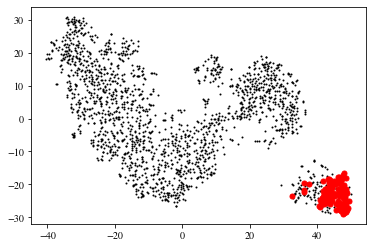

In [39]:
plt.plot(tsne_all_X[10], tsne_all_Y[10], 'ok', ms=1)
plt.plot(tsne_all_X[10][M3_final_ctrl], tsne_all_Y[10][M3_final_ctrl], 'or', ms=5)

In [40]:
M3_tsne_other

[59, 0, 0]

In [41]:
M3_umap_other

[12, 0, 14, 0]

### run again with new control group and no kin

In [42]:
param_list = ['# APOGEE_ID_', 'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
              'RA', 'DEC', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 
              'VHELIO_AVG', 'VERR', 'SNR',
              'FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR',
              'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR',
              'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR',
              'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR',
              'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR']

abundance_index = 13 # index where the first chemical abundance starts
RV_index = 10 # where the radial velocity index is (NOTE: USE VHELIO_AVG NOT THE STUPID GAIA ONE)
PMRA_index = 6 # PMRA index
PMDEC_index = 8 # PMDEC index

# dictionary of all relevant parameters we could ever want for tSNE and UMAP
# the abundances should skip every other one due to it being [chem1, chem1_err, chem2, chem2_err, etc.]
all_param_dict_norad = {'FE_H': abundance_index,
                 'C_FE': abundance_index + 2,
                 'CI_FE': abundance_index + 4,
                 'N_FE': abundance_index + 6,
                 'O_FE': abundance_index + 8,
                 'MG_FE': abundance_index + 10,
                 'AL_FE': abundance_index + 12,
                 'SI_FE': abundance_index + 14,
                 'P_FE': abundance_index + 16,
                 'S_FE': abundance_index + 18,
                 'K_FE': abundance_index + 20,
                 'CA_FE': abundance_index + 22,
                 'TI_FE': abundance_index + 24,
                 'TIII_FE': abundance_index + 26,
                 'V_FE': abundance_index + 28,
                 'CR_FE': abundance_index + 30,
                 'MN_FE': abundance_index + 32,
                 'CO_FE': abundance_index + 34,
                 'NI_FE': abundance_index + 36}


fov = 5 # field of view (note: for x by x, use fov = x/2)
ML_index = 0 # 0 for both tSNE and UMAP, 1 for only tSNE, 2 for only UMAP, any other value will raise an error

In [43]:
def master_func_nokin(GC_name, master_param_dict, fov, db, dataset, params, ML, GC_indices_control):
    print('\nProcessing:', GC_name)
    ML_values = {0, 1, 2}    
    if ML not in ML_values:
        raise ValueError('ML index not one of %r.' % ML_values)
    
    # getting GC parameteters
    ra, dec, rhm_deg, rt_deg = GC_params(GC_name, db)
    
    # loading
    GC_dict, GC_cols = master_load(ra, dec, fov, dataset, params, GC_name, rhm_deg, rt_deg)
    
    # filtering
    GC_filter_data = master_filter(GC_dict, GC_cols)
    
    if GC_filter_data[0].size == 0:
        print("This shit don't got no stars bruh\n")
        return [None, None, None, None, None, None, None, None]
    
    else:
        # choosing parameters
        param_dict = master_param_dict

        if ML == 0:
            # tSNEing
            tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y = master_tSNE(GC_filter_data, param_dict, GC_indices_control, GC_name, GC_filter_data[0].size)

            # UMAPing
            UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y = master_UMAP(GC_filter_data, param_dict, GC_indices_control, GC_name, GC_filter_data[0].size)

            print('Done!\n')
            return [tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y, UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y, GC_indices_control]

        elif ML == 1:
            # tSNEing
            tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y = master_tSNE(GC_filter_data, param_dict, GC_indices_control, GC_filter_data[0].size)

            print('Done!\n')
            return [tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y, None, None, None, None]

        elif ML == 2:
            # UMAPing
            UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y = master_UMAP(GC_filter_data, param_dict, GC_indices_control, GC_filter_data[0].size)

            print('Done!\n')
            return [None, None, None, None, UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y]

In [44]:
GC_stars_dict_norad = {}

test_indices_arr = np.zeros(32, dtype=np.ndarray)

for i in range(len(test_indices_arr)):
    if i == 10:
        test_indices_arr[i] = M3_final_ctrl
    else:
        test_indices_arr[i] = [0, 1]

In [45]:
GC_stars_dict_norad[GC_name_list[10]] = master_func_nokin(GC_name_list[10], all_param_dict_norad, fov, GC_db, apogee_nofilt, param_list, ML_index, M3_final_ctrl)



Processing: NGC_5272
1906 stars in a 10x10 fov of the GC
Directory NGC_5272 already exists

The final amount of stars in our sample is: 1891
Done!



In [46]:
start = time.time()

for count, i in enumerate(tqdm(GC_name_list)):
    GC_stars_dict_norad[i] = master_func_nokin(i, all_param_dict_norad, fov, GC_db, apogee_nofilt, param_list, ML_index, test_indices_arr[count])
    
end = time.time()

print('that shit took', (end - start) / 60, 'mins')


Processing: NGC_104
467 stars in a 10x10 fov of the GC
Directory NGC_104 already exists

The final amount of stars in our sample is: 467
Done!


Processing: NGC_288
293 stars in a 10x10 fov of the GC
Directory NGC_288 already exists

The final amount of stars in our sample is: 287
Done!


Processing: NGC_362
1218 stars in a 10x10 fov of the GC
Directory NGC_362 already exists

The final amount of stars in our sample is: 1215
Done!


Processing: NGC_1851
311 stars in a 10x10 fov of the GC
Directory NGC_1851 already exists

The final amount of stars in our sample is: 307
Done!


Processing: NGC_1904
248 stars in a 10x10 fov of the GC
Directory NGC_1904 already exists

The final amount of stars in our sample is: 246
Done!


Processing: NGC_2808
566 stars in a 10x10 fov of the GC
Directory NGC_2808 already exists

The final amount of stars in our sample is: 565
Done!


Processing: NGC_3201
1065 stars in a 10x10 fov of the GC
Directory NGC_3201 already exists

The final amount of stars in 

### break up into individual arrays

In [61]:
control_stars_list_norad = []
total_stars_list_norad = []

sum = 0
for key in GC_stars_dict_norad:
    #GC_name_list.append(key)
    if GC_stars_dict_norad[key][2] is None:
        control_stars_list_norad.append(0)
        total_stars_list_norad.append(0)
    else:
        sum += 1
        control_stars_list_norad.append(len(GC_stars_dict_norad[key][2]))
        total_stars_list_norad.append(len(GC_stars_dict_norad[key][0]))
    
#print(control_stars_list_norad)
#print(len(GC_name_list_norad))
#print(sum)

In [48]:
new_control_stars_list_norad = []
new_total_stars_list_norad = []
new_stars_index_list_norad = []

for i in range(len(control_stars_list_norad)):
    #print(control_stars_list[i])
    if control_stars_list_norad[i] != 0:
        new_control_stars_list_norad.append(control_stars_list_norad[i])
        new_total_stars_list_norad.append(total_stars_list_norad[i])
        new_stars_index_list_norad.append(i)
        
print(len(new_stars_index_list_norad))

31


In [49]:
GC_name_arr_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)

tsne_control_X_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
tsne_control_Y_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
tsne_all_X_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
tsne_all_Y_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)

umap_control_X_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
umap_control_Y_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
umap_all_X_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
umap_all_Y_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)

control_indices_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)

for i in range(len(new_stars_index_list_norad)):
    ind = new_stars_index_list_norad[i]
    #print(ind)
    GC_name_arr_norad[i] = GC_name_list[ind]
    
    tsne_control_X_norad[i] = GC_stars_dict_norad[GC_name_arr[i]][2]
    tsne_control_Y_norad[i] = GC_stars_dict_norad[GC_name_arr[i]][3]
    tsne_all_X_norad[i] = GC_stars_dict_norad[GC_name_arr[i]][0]
    tsne_all_Y_norad[i] = GC_stars_dict_norad[GC_name_arr[i]][1]
    
    umap_control_X_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][6]
    umap_control_Y_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][7]
    umap_all_X_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][4]
    umap_all_Y_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][5]
    
    control_indices_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][8]

### run the no kin stuff with dbscan and heat map

# need a new function, cant recycle the only db function since that one only found the max group whereas we need to now find the control stars group

In [50]:
def db(name, title, x, y, control_indices):
    plt.clf()
    
    ### setting up data for dbscan
    X = np.c_[x, y] # column stack (i think) for second column for DBSCAN
    
    ### cKDTree to find nearest neighbour distance
    col = np.column_stack([x,y]) # column stack for cKDTree
    tree=cKDTree(col) # making a tree
    dist, arg = tree.query(col, k=2) # querying tree for nearest neighbour distance
    percentile_95 =  np.percentile(dist[:,1], 95) # taking the 95th percentile of that distance
    
    
    ### using the nearest neighbour percentile distance to make eps arrays to cycle through
    eps_const = np.linspace(0.1, 4, 10) # same array that multiplies into the 95th percentile
    eps_arr = eps_const * percentile_95 # eps array to try with DBSCAN
    
    
    ### making min_sample arrays to cycle through
    # use a ball method to count nearest n neighbours within a radius of 95 percentile of nearest neighbouring distance
    ball = tree.query_ball_tree(tree, percentile_95) # ball method where we query a ball of size 95th percentile of nearest neighbour for # of neighbors
    neigh = [len(i) for i in ball]
    neigh_95 = np.percentile(neigh, 95) # 95th percentile of number of neighbors
    
    neigh_const = np.linspace(0.1, 2, 10)
    neigh_arr = neigh_const * neigh_95
    neigh_arr = [int(i) for i in neigh_arr]
    
    # plot of histogram of nearest neighbor numbers in a ball of size 95th percentile of nearest neighbour distances
    # plot of histogram of nearest neighbour distances
    fig, ax = plt.subplots(2, 1, figsize=(24,12))
    ax[0].hist(dist[:,1], color='grey', edgecolor='black')
    ax[0].set_xlabel('Nearest neighbour dist', fontsize=30)
    ax[0].set_title(title + ' nearest neighbour distance w/ 95th percentile as ' + str(percentile_95), fontsize=50)
    ax[1].hist(neigh, color='grey', edgecolor='black')
    ax[1].set_xlabel('# neighbours', fontsize=30)
    ax[1].set_title(title + ' number of neighbour within ' + str(round(percentile_95,3)) + ' w/ 95th percentile as ' + str(round(neigh_95, 3)), fontsize=50)
    plt.tight_layout()
    plt.savefig('GCs_DBSCAN_matrix2/' + name + '/' + title + '_neigh_hist.png')
    fig.clear()
    plt.close(fig)
    
    clusterings_lst = [] # list of clusterings
    labels_lst = [] # list of labels
    n_clusters_lst = [] # list of clusters

    # dbscan
    for i in range(len(neigh_arr)):
        for j in range(len(eps_arr)):
            # all
            db = DBSCAN(eps=eps_arr[j], min_samples=neigh_arr[i]).fit(X)
            clusterings_lst.append(db)
            labels_lst.append(db.labels_)
            n_clusters_lst.append(len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))
    
    unique_labels_lst = []
    core_samples_masks_lst = []
    colors_lst = []
    

    for i in range(len(labels_lst)):
        # all
        unique_labels_lst.append(set(labels_lst[i]))
        core_samples_masks_lst.append(np.zeros_like(labels_lst[i], dtype=bool))
        core_samples_masks_lst[i][clusterings_lst[i].core_sample_indices_] = True
        colors_lst.append([plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_lst[i]))])

    
    # all
    fig, ax = plt.subplots(10, 10, figsize=(150,150))
    for i in range(10):
        for j in range(10):
            for k, col in zip(unique_labels_lst[i + 10*j], colors_lst[i + 10*j]):
                if k == -1:
                    # Black used for noise.
                    lab = 'Noise'
                    col = [0, 0, 0, 1]
                else:
                    lab = 'Group ' + str(k)

                class_member_mask = labels_lst[i + 10*j] == k

                xy = X[class_member_mask & core_samples_masks_lst[i + 10*j]]
                ax[i][j].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor=tuple(col),
                    markeredgecolor="k",
                    markersize=14,
                    label=lab
                )

                xy = X[class_member_mask & ~core_samples_masks_lst[i + 10*j]]
                ax[i][j].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor=tuple(col),
                    markeredgecolor="k",
                    markersize=6,
                )

            ax[i][j].set_xlabel('X', fontsize=40)
            ax[i][j].set_ylabel('Y', fontsize=40)
            ax[i][j].legend(fontsize=20)
            ax[i][j].set_title(name + ' ' + title + f'DBSCAN groups\neps = ' + str(round(eps_arr[i], 2)) + ' min_samples = ' + str(neigh_arr[j]) + f'\nEstimated number of clusters: {n_clusters_lst[i + 10*j]}', fontsize=30)

    plt.tight_layout()
    file_name = 'GCs_DBSCAN_matrix2/' + name + '/' + title + '_dbscan_matrix.png'
    plt.savefig(file_name)
    #plt.show()
    fig.clear()
    plt.close(fig)
    
    
    ### heat map
    
    max_group_label = []
    max_group_count = []

    for ind, labels in enumerate(labels_lst):
        # get unique
        lab, cow = np.unique(labels, return_counts=True)

        # getting index of most control members
        control_labels = labels_lst[ind][control_indices] # labels of the control stars
        #print(control_labels)
        max_lab = st.mode(control_labels)[0][0] # find the most common label
        #print(max_lab)
        max_pos = np.where(lab == max_lab)[0][0] # find the index of that common label for control stars
        #print(cow, max_pos)
        # returning the group label, number of members for largest control star group
        if max_lab == -1: # if the majority of control stars are in the noise
            max_group_label.append(lab[max_pos])
            max_group_count.append(0)
        else:
            max_group_label.append(lab[max_pos])
            max_group_count.append(cow[max_pos])
    
    
    # right now the data is [e1s1, e1s2, e1s3, e1s4, e1s5, e1s6, e1s7, e1s8, e1s9, e1s10, e2s1, e2s2, e2s3, etc.]
    # need to break it up into a 10 by 10
    max_group_count_arr = np.empty((10,10), dtype=int)
    
    for ind, item in enumerate(max_group_count):
        if item >= 0.95 * len(x): # cutting out any ones that are 95% of the data size
            item = 0
        max_group_count_arr[ind%10][ind//10] = item
    
    
    fig, ax = plt.subplots(1, figsize=(12,12))
    im = ax.imshow(max_group_count_arr, cmap='RdPu', interpolation = 'None')
    ax.set_xticks(np.arange(-.5, 9, 1))
    ax.set_yticks(np.arange(-.5, 9, 1))
    ax.set_xticklabels(neigh_arr)
    ax.set_yticklabels(eps_arr)
    ax.set_xlabel('Min Samples')
    ax.set_ylabel('eps')
    #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.grid(color='w', linestyle='-', linewidth=2)
    plt.colorbar(im)
    plt.savefig('GCs_DBSCAN_matrix2/' + name + '/' + title + '_heatmap.png')
    fig.clear()
    plt.close(fig)
    
    # indices for the max section of heat map
    max_eps_ind, max_samp_ind = np.unravel_index(max_group_count_arr.argmax(), max_group_count_arr.shape) 
    
    
    return [eps_arr[max_eps_ind], neigh_arr[max_samp_ind]]

In [62]:
M3_tsne_ctrl_lab

1

In [51]:
temp_max_lab_arr_tsne = np.zeros(32)
temp_max_lab_arr_tsne[10] = M3_tsne_ctrl_lab

In [52]:
start = time.time()

try: 
    os.makedirs('GCs_DBSCAN_matrix2/' + GC_name_arr[10])
except OSError as error:
    print('Directory ' + GC_name_arr[10] + ' already exists')

M3_tsne_eps_all, M3_tsne_samp_all = db(GC_name_arr[10], 'tsne', tsne_all_X_norad[10], tsne_all_Y_norad[10], control_indices_norad[10])
M3_umap_eps_all, M3_umap_samp_all = db(GC_name_arr[10], 'umap', umap_all_X_norad[10], umap_all_Y_norad[10], control_indices_norad[10])

end = time.time()
print('That shit took ', (end - start) / 60, ' mins')

Directory NGC_5272 already exists


<ipython-input-50-7eaaebea87e3>:109: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()
<ipython-input-50-7eaaebea87e3>:109: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


That shit took  4.242466203371683  mins


<Figure size 432x288 with 0 Axes>

### M3 choosing eps and min samp

In [53]:
M3_tsne_all_labels = db_opt(GC_name_arr[10], 'tsne', tsne_all_X[10], tsne_all_Y[10], M3_tsne_eps_all, M3_tsne_samp_all)
M3_umap_all_labels = db_opt(GC_name_arr[10], 'umap', umap_all_X[10], umap_all_Y[10], M3_umap_eps_all, M3_umap_samp_all)

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

### Now we need to match control stars to the right group

In [54]:
def final_et(control_indices, labels_tsne, labels_umap):
    ### first find the most common control star label
    tsne_et_ind = []
    umap_et_ind = []
    
    # get unique
    lab_tsne, cow_tsne = np.unique(labels_tsne, return_counts=True)
    lab_umap, cow_umap = np.unique(labels_tsne, return_counts=True)

    # getting index of most control members
    control_labels_tsne = labels_tsne[control_indices] # labels of the control stars
    max_lab_tsne = st.mode(control_labels_tsne)[0][0] # find the most common label
    
    control_labels_umap = labels_umap[control_indices] # labels of the control stars
    print(len(control_labels_umap))
    max_lab_umap = st.mode(control_labels_umap)[0][0] # find the most common label

    for ind, labels in enumerate(labels_tsne):
        if labels == max_lab_tsne:
            tsne_et_ind.append(ind)
    
    for ind, labels in enumerate(labels_umap):
        if labels == max_lab_umap:
            umap_et_ind.append(ind)
    
    final_tsne = []
    final_umap = []
    final_et = []
    
    for i in tsne_et_ind:
        if i in umap_et_ind and i not in control_indices:
            final_et.append(i)
    
    for i in tsne_et_ind:
        if i not in control_indices:
            final_tsne.append(i)
            
    for i in umap_et_ind:
        if i not in control_indices:
            final_umap.append(i)
            
    return [final_et, final_tsne, final_umap]

In [55]:
M3_final_et, M3_final_tsne, M3_final_umap = final_et(control_indices_norad[10], M3_tsne_all_labels, M3_umap_all_labels)

118


In [56]:
len(M3_final_et)

97

In [57]:
len(M3_final_tsne)

98

In [58]:
len(M3_final_umap)

101

In [59]:
def plot_shit(name, n, final_et):
    #plt.close('all')
    M3_ra = GC_db['RA'][n]
    M3_dec = GC_db['DEC'][n]
    M3_rt = GC_db['rt'][n]
    M3_d_Sun = GC_db['R_Sun'][n] * 1e3
    M3_rt_deg = math.degrees(math.atan(M3_rt / M3_d_Sun))
    M3_fov = 5

    M3_stars = []
    for count, i in enumerate(apogee_nofilt['RA'].values):
        if i >= M3_ra - M3_fov and i <= M3_ra + M3_fov and apogee_nofilt['DEC'].values[count] >= M3_dec - M3_fov and apogee_nofilt['DEC'].values[count] <= M3_dec + M3_fov:
            M3_stars.append(apogee_nofilt.loc[count])

    print(len(M3_stars), 'stars in a 10x10 fov of the GC')

    '''if len(M3_stars) != 0:
        # create a folder with name of GC only if there are stars in the field
        try: 
            os.makedirs('GCs_nice/' + name)
        except OSError as error:
            print('Directory ' + name+ ' already exists')'''

    M3_ra_arr = np.empty(len(M3_stars), dtype=float)
    M3_dec_arr = np.empty(len(M3_stars), dtype=float)
    for count, i in enumerate(M3_stars):
        M3_ra_arr[count] = i['RA']
        M3_dec_arr[count] = i['DEC']     
        
    #M3_rhm_circ = plt.Circle((M3_ra, M3_dec), M3_rhm_deg, color='r', fill=False, label='rhm')
    #M3_rhm_rt_circ = plt.Circle((M3_ra, M3_dec), (rhm_deg + rt_deg)/2, color='g', fill=False, label='1/2 rhm, rt')
    M3_rt_circ = plt.Circle((M3_ra, M3_dec), M3_rt_deg, color='b', fill=False, label='rt')
    
    try: 
        os.makedirs('GCs_test/' + GC_name_arr[n])
    except OSError as error:
        print('Directory ' + GC_name_arr[n] + ' already exists')
    
    #plt.figure(figsize=(10,10))
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.plot(M3_ra_arr, M3_dec_arr, 'ok', linestyle='none', markersize=1, label='Stars')
    ax.plot(M3_ra, M3_dec, color='cyan', marker='x', linestyle='none', markersize=5, label='GC centre')
    ax.plot(M3_ra_arr[final_et], M3_dec_arr[final_et], color='fuchsia', linestyle='none', marker='*', ms=5, label='ET Candidates')
    #ax.add_patch(rhm_circ)
    #ax.add_patch(rhm_rt_circ)
    ax.add_patch(M3_rt_circ)
    ax.set_xlabel('RA', fontsize=20)
    ax.set_ylabel('DEC', fontsize=20)
    ax.set_title('Final stars for ' + GC_name_arr[n], fontsize=20)
    ax.set_xlim(M3_ra - M3_fov - 1, M3_ra + M3_fov + 1)
    ax.set_ylim(M3_dec - M3_fov - 1, M3_dec + M3_fov + 1)
    ax.legend(loc='best', fontsize=20)
    plt.savefig('GCs_DBSCAN_matrix2/' + name + '/final_et.png')
    plt.show()
    
    '''fig, ax = plt.subplots(2, 2, figsize=(20,20))
    
    # all tsne
    ax[0][0].plot(tsne_all_X[n], tsne_all_Y[n], 'ok', ms=1, label='All stars')
    ax[0][0].plot(tsne_control_X[n][0], tsne_control_Y[n][0], 'or', ms=3, label='Control stars')
    ax[0][0].plot(tsne_all_X[n][tsne_et_stars_index[n]], tsne_all_Y[n][tsne_et_stars_index[n]], 'ob', ms=5, label='ET stars', alpha=0.3)
    ax[0][0].set_title('tsne all params', fontsize=20)
    ax[0][0].legend(fontsize=20)
    
    # all umap
    ax[0][1].plot(umap_all_X[n], umap_all_Y[n], 'ok', ms=1, label='All stars')
    ax[0][1].plot(umap_control_X[n][0], umap_control_Y[n][0], 'or', ms=3, label='Control stars')
    ax[0][1].plot(umap_all_X[n][umap_et_stars_index[n]], umap_all_Y[n][umap_et_stars_index[n]], 'ob', ms=5, label='ET stars', alpha=0.3)
    ax[0][1].set_title('umap all params', fontsize=20)
    ax[0][1].legend(fontsize=20)
    
    # no pm, rv tsne
    ax[1][0].plot(tsne_all_X_norad[n], tsne_all_Y_norad[n], 'ok', ms=1, label='All stars')
    ax[1][0].plot(tsne_control_X_norad[n][0], tsne_control_Y_norad[n][0], 'or', ms=3, label='Control stars')
    ax[1][0].plot(tsne_all_X_norad[n][tsne_et_stars_index_norad[n]], tsne_all_Y_norad[n][tsne_et_stars_index_norad[n]], 'ob', ms=5, label='ET stars', alpha=0.3)
    ax[1][0].set_title('tsne no pm, rv', fontsize=20)
    ax[1][0].legend(fontsize=20)
    
    # no pm, rv umap
    ax[1][1].plot(umap_all_X_norad[n], umap_all_Y_norad[n], 'ok', ms=1, label='All stars')
    ax[1][1].plot(umap_control_X_norad[n][0], umap_control_Y_norad[n][0], 'or', ms=3, label='Control stars')
    ax[1][1].plot(umap_all_X_norad[n][umap_et_stars_index_norad[n]], umap_all_Y_norad[n][umap_et_stars_index_norad[n]], 'ob', ms=5, label='ET stars', alpha=0.3)
    ax[1][1].set_title('umap no pm, rv', fontsize=20)
    ax[1][1].legend(fontsize=20)
    
    plt.tight_layout()
    plt.show()'''


1906 stars in a 10x10 fov of the GC
Directory NGC_5272 already exists


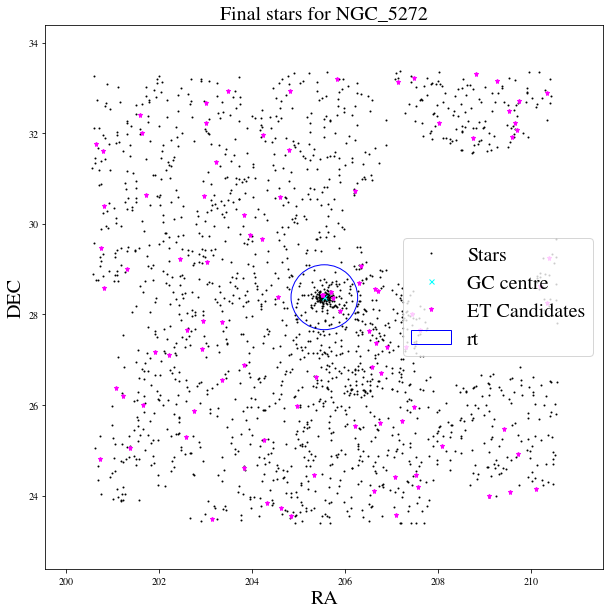

In [60]:
plot_shit(GC_name_arr[10], 10, M3_final_et)

In [224]:
a = [2,2,2,4,2,3,5,7,8,9]
b = st.mode(a)[0][0]

b == 2

True

### step 1.5 heat map for ctrl

In [ ]:
M3_ctrl_labels = []
M3_ctrl_count = []

max_group_label = []
max_group_count = []

for ind, counts in enumerate(M3_tsne_labels_ctrl[0]):
    labels, count = np.unique(counts, return_counts=True)
    
    # getting index of most members
    max_pos = np.argmax(count)
    # returning the group label, number of members for largest group
    max_group_label.append(labels[max_pos])
    max_group_count.append(count[max_pos])
    


In [ ]:
# right now the data is [e1s1, e1s2, e1s3, e1s4, e1s5, e1s6, e1s7, e1s8, e1s9, e1s10, e2s1, e2s2, e2s3, etc.]
# need to break it up into a 10 by 10
max_group_count_arr = np.empty((10,10), dtype=int)


for ind, item in enumerate(max_group_count):
    if item >= 0.95 * len(control_indices_rad[11][0][0]):
        item = 0
    max_group_count_arr[ind//10][ind%10] = item

In [ ]:
max_group_count_arr

In [ ]:
eps_arr = np.linspace(0.1, 2, 10)
neigh_arr = np.linspace(1, 40, 10)

In [ ]:
fig, ax = plt.subplots(1)

im = ax.imshow(max_group_count_arr, cmap='Pastel1', interpolation = 'None', vmin=0, vmax=1)

ax.set_xticklabels(eps_arr)
ax.set_yticklabels(neigh_arr)

ax.set_xticks(np.arange(-.5, 10, 1))
ax.set_yticks(np.arange(-.5, 10, 1))

ax.grid(color='w', linestyle='-', linewidth=2)
plt.colorbar(im)



In [ ]:
tsne_db_labels = [[] for _ in range(len(GC_name_arr))]
umap_db_labels = [[] for _ in range(len(GC_name_arr))]

start = time.time()

for i in tqdm(range(26, len(GC_name_arr))):
    plt.clf()
    try: 
        os.makedirs('GCs_DBSCAN_matrix/' + GC_name_arr[i])
    except OSError as error:
        print('Directory ' + GC_name_arr[i] + ' already exists')

    plot_ML(GC_name_arr[i], [tsne_control_X[i][0], tsne_control_Y[i][0], tsne_all_X[i], tsne_all_Y[i]], [umap_control_X[i][0], umap_control_Y[i][0], umap_all_X[i], umap_all_Y[i]])

    tsne_db_labels[i].append(db(GC_name_arr[i], 'tsne', tsne_all_X[i], tsne_all_Y[i], tsne_control_X[i][0], tsne_control_Y[i][0])) # tsne
    umap_db_labels[i].append(db(GC_name_arr[i], 'umap', umap_all_X[i], umap_all_Y[i], umap_control_X[i][0], umap_control_Y[i][0])) # umap


    print('Done ' + GC_name_arr[i])
    
end = time.time()
print('That shit took ', (end - start) / 60, ' mins')

### run it again without proper motion and radial velocities

In [ ]:
param_list = ['# APOGEE_ID_', 'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
              'RA', 'DEC', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 
              'VHELIO_AVG', 'VERR', 'SNR',
              'FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR',
              'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR',
              'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR',
              'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR',
              'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR']

abundance_index = 13 # index where the first chemical abundance starts
RV_index = 10 # where the radial velocity index is (NOTE: USE VHELIO_AVG NOT THE STUPID GAIA ONE)
PMRA_index = 6 # PMRA index
PMDEC_index = 8 # PMDEC index

# dictionary of all relevant parameters we could ever want for tSNE and UMAP
# the abundances should skip every other one due to it being [chem1, chem1_err, chem2, chem2_err, etc.]
all_param_dict_norad = {'FE_H': abundance_index,
                 'C_FE': abundance_index + 2,
                 'CI_FE': abundance_index + 4,
                 'N_FE': abundance_index + 6,
                 'O_FE': abundance_index + 8,
                 'MG_FE': abundance_index + 10,
                 'AL_FE': abundance_index + 12,
                 'SI_FE': abundance_index + 14,
                 'P_FE': abundance_index + 16,
                 'S_FE': abundance_index + 18,
                 'K_FE': abundance_index + 20,
                 'CA_FE': abundance_index + 22,
                 'TI_FE': abundance_index + 24,
                 'TIII_FE': abundance_index + 26,
                 'V_FE': abundance_index + 28,
                 'CR_FE': abundance_index + 30,
                 'MN_FE': abundance_index + 32,
                 'CO_FE': abundance_index + 34,
                 'NI_FE': abundance_index + 36}


fov = 5 # field of view (note: for x by x, use fov = x/2)
ML_index = 0 # 0 for both tSNE and UMAP, 1 for only tSNE, 2 for only UMAP, any other value will raise an error

In [ ]:
start = time.time()

for count, i in enumerate(tqdm(GC_name_list)):
    GC_stars_dict_norad[i] = master_func_auto(i, all_param_dict_norad, fov, GC_db, apogee_nofilt, param_list, ML_index)
    
end = time.time()

print('that shit took', (end - start) / 60, 'mins')

#### without pm and rv

In [ ]:
print(len(GC_stars_dict_norad))

#GC_name_list = []
control_stars_list_norad = []
total_stars_list_norad = []

sum = 0
for key in GC_stars_dict_norad:
    #GC_name_list.append(key)
    if GC_stars_dict_norad[key][2] is None:
        control_stars_list_norad.append(0)
        total_stars_list_norad.append(0)
    else:
        sum += 1
        control_stars_list_norad.append(len(GC_stars_dict_norad[key][2]))
        total_stars_list_norad.append(len(GC_stars_dict_norad[key][0]))
    
#print(control_stars_list_norad)
#print(len(GC_name_list_norad))
#print(sum)

In [ ]:
new_control_stars_list_norad = []
new_total_stars_list_norad = []
new_stars_index_list_norad = []

for i in range(len(control_stars_list_norad)):
    #print(control_stars_list[i])
    if control_stars_list_norad[i] != 0:
        new_control_stars_list_norad.append(control_stars_list_norad[i])
        new_total_stars_list_norad.append(total_stars_list_norad[i])
        new_stars_index_list_norad.append(i)
        
print(len(new_stars_index_list_norad))

In [ ]:
GC_name_arr_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)

tsne_control_X_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
tsne_control_Y_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
tsne_all_X_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
tsne_all_Y_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)

umap_control_X_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
umap_control_Y_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
umap_all_X_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
umap_all_Y_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)

control_indices_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)

for i in range(len(new_stars_index_list_norad)):
    ind = new_stars_index_list_norad[i]
    #print(ind)
    GC_name_arr_norad[i] = GC_name_list_norad[ind]
    
    tsne_control_X_norad[i] = GC_stars_dict_norad[GC_name_arr[i]][2]
    tsne_control_Y_norad[i] = GC_stars_dict_norad[GC_name_arr[i]][3]
    tsne_all_X_norad[i] = GC_stars_dict_norad[GC_name_arr[i]][0]
    tsne_all_Y_norad[i] = GC_stars_dict_norad[GC_name_arr[i]][1]
    
    umap_control_X_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][6]
    umap_control_Y_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][7]
    umap_all_X_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][4]
    umap_all_Y_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][5]
    
    control_indices_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][8]

In [ ]:
def db(name, title, x, y, x_ctrl, y_ctrl):       
    plt.clf()
    
    ### setting up data for dbscan
    X = np.c_[x, y] # column stack (i think) for second column for DBSCAN
    X_ctrl = np.c_[x_ctrl, y_ctrl]
    
    ### cKDTree to find nearest neighbour distance
    # all stars
    col = np.column_stack([x,y]) # column stack for cKDTree
    tree=cKDTree(col) # making a tree
    dist, arg = tree.query(col, k=2) # querying tree for nearest neighbour distance
    percentile_95 =  np.percentile(dist[:,1], 95) # taking the 95th percentile of that distance
    
    # control stars
    col_ctrl = np.column_stack([x_ctrl,y_ctrl])
    tree_ctrl = cKDTree(col_ctrl)
    dist_ctrl, arg_ctrl = tree_ctrl.query(col_ctrl, k=2)
    percentile_95_ctrl = np.percentile(dist_ctrl[:,1], 95)

    
    ### plot of histogram of nearest neighbour distances
    fig, ax = plt.subplots(2, 1, figsize=(24,12))
    ax[0].hist(dist_ctrl[:,1], color='grey', edgecolor='black')
    ax[0].set_xlabel('Nearest neighbour dist', fontsize=30)
    ax[0].set_title(title + ' ctrl stars nearest neighbour distance w/ 95th percentile as ' + str(percentile_95_ctrl), fontsize=50)
    ax[1].hist(dist[:,1], color='grey', edgecolor='black')
    ax[1].set_xlabel('Nearest neighbour dist', fontsize=30)
    ax[1].set_title(title + ' all stars nearest neighbour distance w/ 95th percentile as ' + str(percentile_95), fontsize=50)
    plt.tight_layout()
    plt.savefig('GCs_DBSCAN_matrix/' + name + '/eps_hist.png')
    
    
    ### using the nearest neighbour percentile distance to make eps arrays to cycle through
    eps_const = np.linspace(0.1, 4, 10) # same array that multiplies into the 95th percentile
    eps_arr = eps_const * percentile_95 # eps array to try with DBSCAN
    eps_arr_ctrl = eps_const * percentile_95_ctrl
    
    
    ### making min_sample arrays to cycle through with 2 diff options:
    # 1. use a diff sample array for the control and all stars. this is some set fraction of the stars
    # 2. use the same sample array of 1 to # of control stars
    # 3. use a ball method to count nearest n neighbours within a radius of 95 percentile of nearest neighbouring distance
    # method 1
    beta = 0.9 * len(x) # set 90% of stars
    samp_const = np.linspace(0.01, 2 * len(x_ctrl) / len(x), 10) # constant to multiply the min samples thingy, going from 0.01 to twice the ratio of ctlr to all stars
    samp_arr = samp_const * int(max(1, round(beta))) # array for min samples for all stars
    samp_arr = [int(i) for i in samp_arr]
    
    beta_ctrl = 0.9 * len(x_ctrl) # set 90% of stars
    samp_arr_ctrl = samp_const * int(max(1, round(beta_ctrl)))
    samp_arr_ctrl = [int(i) for i in samp_arr_ctrl]
    
    # method 2
    samp_arr_both = np.linspace(1, len(x_ctrl), 10) # test array 1 for min samples for ctrl stars. this is diff as all stars is usually way too big for ctrl star purposes
    samp_arr_both = [int(i) for i in samp_arr_both]
    
    # method 3
    ball = tree.query_ball_tree(tree, percentile_95) # ball method where we query a ball of size 95th percentile of nearest neighbour for # of neighbors
    neigh = [len(i) for i in ball]
    neigh_95 = np.percentile(neigh, 95) # 95th percentile of number of neighbors
    
    neigh_const = np.linspace(0.1, 2, 10)
    neigh_arr = neigh_const * neigh_95
    neigh_arr = [int(i) for i in neigh_arr]
                                
    ball_ctrl = tree_ctrl.query_ball_tree(tree_ctrl, percentile_95_ctrl)
    neigh_ctrl = [len(i) for i in ball_ctrl]
    neigh_95_ctrl = np.percentile(neigh_ctrl, 95)
    
    neigh_const = np.linspace(0.1, 2, 10)
    neigh_arr_ctrl = neigh_const * neigh_95_ctrl
    neigh_arr_ctrl = [int(i) for i in neigh_arr_ctrl]
    
    # plot of histogram of nearest neighbor numbers in a ball of size 95th percentile of nearest neighbour distances
    fig, ax = plt.subplots(2, 1, figsize=(24,12))
    ax[0].hist(neigh_ctrl, color='grey', edgecolor='black')
    ax[0].set_xlabel('# neighbours', fontsize=30)
    ax[0].set_title(title + ' ctrl stars number of neighbour within ' + str(round(percentile_95_ctrl,3)) + ' w/ 95th percentile as ' + str(round(neigh_95_ctrl, 3)), fontsize=50)
    ax[1].hist(neigh, color='grey', edgecolor='black')
    ax[1].set_xlabel('# neighbours', fontsize=30)
    ax[1].set_title(title + ' all stars number of neighbour within ' + str(round(percentile_95,3)) + ' w/ 95th percentile as ' + str(round(neigh_95, 3)), fontsize=50)
    plt.tight_layout()
    plt.savefig('GCs_DBSCAN_matrix/' + name + '/neigh_hist.png')
    
    
    clusterings_lst = [] # list of clusterings
    labels_lst = [] # list of labels
    n_clusters_lst = [] # list of clusters
    
    clusterings_lst_ctrl = []
    labels_lst_ctrl = []
    n_clusters_lst_ctrl = []

    # dbscan
    for i in range(len(eps_arr)):
        for j in range(len(samp_arr)):
            # all stars
            db = DBSCAN(eps=eps_arr[i], min_samples=neigh_arr[j]).fit(X)
            clusterings_lst.append(db)
            labels_lst.append(db.labels_)
            n_clusters_lst.append(len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))

            # ctrl stars
            db_ctrl = DBSCAN(eps=eps_arr_ctrl[i], min_samples=neigh_arr_ctrl[j]).fit(X_ctrl)
            clusterings_lst_ctrl.append(db_ctrl)
            labels_lst_ctrl.append(db_ctrl.labels_)
            n_clusters_lst_ctrl.append(len(set(db_ctrl.labels_)) - (1 if -1 in db_ctrl.labels_ else 0))
    
    unique_labels_lst = []
    core_samples_masks_lst = []
    colors_lst = []
    
    unique_labels_lst_ctrl = []
    core_samples_masks_lst_ctrl = []
    colors_lst_ctrl = []

    for i in range(len(labels_lst)):
        # all
        unique_labels_lst.append(set(labels_lst[i]))
        core_samples_masks_lst.append(np.zeros_like(labels_lst[i], dtype=bool))
        core_samples_masks_lst[i][clusterings_lst[i].core_sample_indices_] = True
        colors_lst.append([plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_lst[i]))])
        
        # ctrl
        unique_labels_lst_ctrl.append(set(labels_lst_ctrl[i]))
        core_samples_masks_lst_ctrl.append(np.zeros_like(labels_lst_ctrl[i], dtype=bool))
        core_samples_masks_lst_ctrl[i][clusterings_lst_ctrl[i].core_sample_indices_] = True
        colors_lst_ctrl.append([plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_lst_ctrl[i]))])

    
    # all
    fig, ax = plt.subplots(10, 10, figsize=(200,200))
    for i in range(10):
        for j in range(10):
            for k, col in zip(unique_labels_lst[i + 10*j], colors_lst[i + 10*j]):
                if k == -1:
                    # Black used for noise.
                    lab = 'Noise'
                    col = [0, 0, 0, 1]
                else:
                    lab = 'Group ' + str(k)

                class_member_mask = labels_lst[i + 10*j] == k

                xy = X[class_member_mask & core_samples_masks_lst[i + 10*j]]
                ax[i][j].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor=tuple(col),
                    markeredgecolor="k",
                    markersize=14,
                    label=lab
                )

                xy = X[class_member_mask & ~core_samples_masks_lst[i + 10*j]]
                ax[i][j].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor=tuple(col),
                    markeredgecolor="k",
                    markersize=6,
                )

            ax[i][j].set_xlabel('X', fontsize=40)
            ax[i][j].set_ylabel('Y', fontsize=40)
            ax[i][j].legend(fontsize=20)
            ax[i][j].set_title(name + ' ' + title + f' all stars DBSCAN groups\neps = ' + str(round(eps_arr[j], 2)) + ' min_samples = ' + str(neigh_arr[i]) + f'\nEstimated number of clusters: {n_clusters_lst[i + 10*j]}', fontsize=30)

    plt.tight_layout()
    file_name = 'GCs_DBSCAN_matrix/' + name + '/db_all_' + title + '_tree_ball.png'
    plt.savefig(file_name)
    #plt.show()
    
    # ctrl
    fig, ax = plt.subplots(10, 10, figsize=(200,200))
    for i in range(10):
        for j in range(10):
            for k, col in zip(unique_labels_lst_ctrl[i + 10*j], colors_lst_ctrl[i + 10*j]):
                if k == -1:
                    # Black used for noise.
                    lab = 'Noise'
                    col = [0, 0, 0, 1]
                else:
                    lab = 'Group ' + str(k)

                class_member_mask = labels_lst_ctrl[i + 5*j] == k

                xy = X_ctrl[class_member_mask & core_samples_masks_lst_ctrl[i + 10*j]]
                ax[i][j].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor=tuple(col),
                    markeredgecolor="k",
                    markersize=14,
                    label=lab
                )

                xy = X_ctrl[class_member_mask & ~core_samples_masks_lst_ctrl[i + 10*j]]
                ax[i][j].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor=tuple(col),
                    markeredgecolor="k",
                    markersize=6,
                )

            ax[i][j].set_xlabel('X', fontsize=40)
            ax[i][j].set_ylabel('Y', fontsize=40)
            ax[i][j].legend(fontsize=20)
            ax[i][j].set_title(name + ' ' + title + f' ctrl stars DBSCAN groups\neps = ' + str(round(eps_arr_ctrl[j], 2)) + ' min_samples = ' + str(neigh_arr_ctrl[i]) + f'\nEstimated number of clusters: {n_clusters_lst_ctrl[i + 10*j]}', fontsize=30)

    plt.tight_layout()
    file_name = 'GCs_DBSCAN_matrix/' + name + '/db_ctrl_' + title + '_tree_ball.png'
    plt.savefig(file_name)
    #plt.show()
    
    plt.clf()
    
    return [labels_lst, labels_lst_ctrl]

In [ ]:
tsne_db_labels = [[] for _ in range(len(GC_name_arr))]
umap_db_labels = [[] for _ in range(len(GC_name_arr))]

start = time.time()

for i in tqdm(range(26, len(GC_name_arr))):
    plt.clf()
    try: 
        os.makedirs('GCs_DBSCAN_matrix/' + GC_name_arr[i])
    except OSError as error:
        print('Directory ' + GC_name_arr[i] + ' already exists')

    plot_ML(GC_name_arr[i], [tsne_control_X[i][0], tsne_control_Y[i][0], tsne_all_X[i], tsne_all_Y[i]], [umap_control_X[i][0], umap_control_Y[i][0], umap_all_X[i], umap_all_Y[i]])

    tsne_db_labels[i].append(db(GC_name_arr[i], 'tsne', tsne_all_X[i], tsne_all_Y[i], tsne_control_X[i][0], tsne_control_Y[i][0])) # tsne
    umap_db_labels[i].append(db(GC_name_arr[i], 'umap', umap_all_X[i], umap_all_Y[i], umap_control_X[i][0], umap_control_Y[i][0])) # umap


    print('Done ' + GC_name_arr[i])
    
end = time.time()
print('That shit took ', (end - start) / 60, ' mins')
    

In [ ]:

    
tsne_ctrl_db_labels = []
tsne_all_db_labels = []
umap_ctrl_db_labels = []
umap_all_db_labels = []

for n in tqdm(range(len(GC_name_arr))):
    try: 
        os.makedirs('GCs_DBSCAN_matrix/' + GC_name_arr[n])
    except OSError as error:
        print('Directory ' + GC_name_arr[n] + ' already exists')
    
    plot_ML(GC_name_arr[n], [tsne_control_X[n][0], tsne_control_Y[n][0], tsne_all_X[n], tsne_all_Y[n]], [umap_control_X[n][0], umap_control_Y[n][0], umap_all_X[n], umap_all_Y[n]])
    
    tsne_X_ctrl = np.c_[tsne_control_X[n][0], tsne_control_Y[n][0]]
    tsne_X_all = np.c_[tsne_all_X[n], tsne_all_Y[n]]
    umap_X_ctrl = np.c_[umap_control_X[n][0], umap_control_Y[n][0]]
    umap_X_all = np.c_[umap_all_X[n], umap_all_Y[n]]
    
    
    
    tsne_ctrl_db_labels.append(db_ctrl_tsne_2(GC_name_arr[n], tsne_X_ctrl))
    tsne_all_db_labels.append(db_all_tsne_2(GC_name_arr[n], tsne_X_all))
    umap_ctrl_db_labels.append(db_ctrl_umap_2(GC_name_arr[n], umap_X_ctrl))
    umap_all_db_labels.append(db_all_umap_2(GC_name_arr[n], umap_X_all))
    
    print('Done ' + GC_name_arr[n])
    

In [ ]:
def db_ctrl_umap(name, umap_X_ctrl):
    plt.close('all')
    eps_arr_umap = np.arange(0.1, 3., 0.2)
    clusterings_umap_ctrl_lst = []
    labels_umap_ctrl_lst = []
    n_clusters_umap_ctrl_lst = []

    for i in eps_arr_umap:
        db = DBSCAN(eps=i, min_samples = 10).fit(umap_X_ctrl)
        clusterings_umap_ctrl_lst.append(db)
        labels_umap_ctrl_lst.append(db.labels_)
        n_clusters_umap_ctrl_lst.append(len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))
    
    unique_labels_umap_ctrl_lst = []
    core_samples_masks_umap_ctrl_lst = []
    colors_umap_ctrl_lst = []

    for i in range(len(labels_umap_ctrl_lst)):
        unique_labels_umap_ctrl_lst.append(set(labels_umap_ctrl_lst[i]))
        core_samples_masks_umap_ctrl_lst.append(np.zeros_like(labels_umap_ctrl_lst[i], dtype=bool))
        core_samples_masks_umap_ctrl_lst[i][clusterings_umap_ctrl_lst[i].core_sample_indices_] = True

        colors_umap_ctrl_lst.append([plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_umap_ctrl_lst[i]))])

    fig, ax = plt.subplots(3, 5, figsize=(80,50))

    for i in range(5):
        for j in range(3):
            for k, col in zip(unique_labels_umap_ctrl_lst[i + 5*j], colors_umap_ctrl_lst[i + 5*j]):
                if k == -1:
                    # Black used for noise.
                    lab = 'Noise'
                    col = [0, 0, 0, 1]
                else:
                    lab = 'Group ' + str(k)

                class_member_mask = labels_umap_ctrl_lst[i + 5*j] == k

                xy = umap_X_ctrl[class_member_mask & core_samples_masks_umap_ctrl_lst[i + 5*j]]
                ax[j][i].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor=tuple(col),
                    markeredgecolor="k",
                    markersize=14,
                    label=lab
                )

                xy = umap_X_ctrl[class_member_mask & ~core_samples_masks_umap_ctrl_lst[i + 5*j]]
                ax[j][i].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor=tuple(col),
                    markeredgecolor="k",
                    markersize=6,
                )

            ax[j][i].set_xlabel('umap X', fontsize=40)
            ax[j][i].set_ylabel('umap Y', fontsize=40)
            ax[j][i].legend(fontsize=20)
            ax[j][i].set_title(name + f" umap ctrl Stars DBSCAN groups\neps = " + str(round(eps_arr_umap[i + 5*j], 2)) + ' min_samples = 10' + f"\nEstimated number of clusters: {n_clusters_umap_ctrl_lst[i + 5*j]}", fontsize=50)

    plt.tight_layout()
    file_name = 'GCs_DBSCAN/' + name + '/db_umap_ctrl.png'
    plt.savefig(file_name)
    #plt.show()
    
    return labels_umap_ctrl_list

In [ ]:
def db_all_umap_2(name, umap_X_all):
    plt.close('all')
    #eps_arr_umap = np.arange(0.1, 3., 0.2)
    
    db_umap_all = DBSCAN(eps=2, min_samples = 10).fit(umap_X_all)
    labels_umap_all_2 = db_umap_all.labels_
    n_clusters_umap_all_2 = len(set(db_umap_all.labels_)) - (1 if -1 in db_umap_all.labels_ else 0)

    unique_labels_umap_all_2 = set(labels_umap_all_2)
    core_samples_masks_umap_all_2 = np.zeros_like(labels_umap_all_2, dtype=bool)
    core_samples_masks_umap_all_2[db_umap_all.core_sample_indices_] = True

    colors_umap_all_2 = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_umap_all_2))]

    fig, ax = plt.subplots(1, figsize=(80,50))

    for k, col in zip(unique_labels_umap_all_2, colors_umap_all_2):
        if k == -1:
            # Black used for noise.
            lab = 'Noise'
            col = [0, 0, 0, 1]
        else:
            lab = 'Group ' + str(k)

        class_member_mask = labels_umap_all_2 == k

        xy = umap_X_all[class_member_mask & core_samples_masks_umap_all_2]
        ax.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
            label=lab
        )

        xy = umap_X_all[class_member_mask & ~core_samples_masks_umap_all_2]
        ax.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

    ax.set_xlabel('umap X', fontsize=40)
    ax.set_ylabel('umap Y', fontsize=40)
    ax.legend(fontsize=20)
    ax.set_title(name + f'umap all Stars DBSCAN groups\neps = 2, min_samples = 10' + f"\nEstimated number of clusters: {n_clusters_umap_all_2}", fontsize=50)

    plt.tight_layout()
    file_name = 'GCs_DBSCAN_set_eps_norad/' + name + '/db_umap_all.png'
    #plt.savefig(file_name)
    #plt.show()
    
    return labels_umap_all_2

#### all params

In [ ]:
tsne_ctrl_db_labels = []
tsne_all_db_labels = []
umap_ctrl_db_labels = []
umap_all_db_labels = []

for n in tqdm(range(len(GC_name_arr))):
    '''try: 
        os.makedirs('GCs_DBSCAN_set_eps/' + GC_name_arr[n])
    except OSError as error:
        print('Directory ' + GC_name_arr[n] + ' already exists')'''
    
    plot_ML(GC_name_arr[n], [tsne_control_X[n][0], tsne_control_Y[n][0], tsne_all_X[n], tsne_all_Y[n]], [umap_control_X[n][0], umap_control_Y[n][0], umap_all_X[n], umap_all_Y[n]])
    
    tsne_X_ctrl = np.c_[tsne_control_X[n][0], tsne_control_Y[n][0]]
    tsne_X_all = np.c_[tsne_all_X[n], tsne_all_Y[n]]
    umap_X_ctrl = np.c_[umap_control_X[n][0], umap_control_Y[n][0]]
    umap_X_all = np.c_[umap_all_X[n], umap_all_Y[n]]
    
    
    
    tsne_ctrl_db_labels.append(db_ctrl_tsne_2(GC_name_arr[n], tsne_X_ctrl))
    tsne_all_db_labels.append(db_all_tsne_2(GC_name_arr[n], tsne_X_all))
    umap_ctrl_db_labels.append(db_ctrl_umap_2(GC_name_arr[n], umap_X_ctrl))
    umap_all_db_labels.append(db_all_umap_2(GC_name_arr[n], umap_X_all))
    
    print('Done ' + GC_name_arr[n])
    

#### no kin

In [ ]:
tsne_ctrl_db_labels_norad = []
tsne_all_db_labels_norad = []
umap_ctrl_db_labels_norad = []
umap_all_db_labels_norad = []

for n in tqdm(range(len(GC_name_arr_norad))):
    '''try: 
        os.makedirs('GCs_DBSCAN_set_eps_norad/' + GC_name_arr_norad[n])
    except OSError as error:
        print('Directory ' + GC_name_arr_norad[n] + ' already exists')'''
    
    plot_ML(GC_name_arr_norad[n], [tsne_control_X_norad[n][0], tsne_control_Y_norad[n][0], tsne_all_X_norad[n], tsne_all_Y_norad[n]], [umap_control_X_norad[n][0], umap_control_Y_norad[n][0], umap_all_X_norad[n], umap_all_Y_norad[n]])
    
    tsne_X_ctrl_norad = np.c_[tsne_control_X_norad[n][0], tsne_control_Y_norad[n][0]]
    tsne_X_all_norad = np.c_[tsne_all_X_norad[n], tsne_all_Y_norad[n]]
    umap_X_ctrl_norad = np.c_[umap_control_X_norad[n][0], umap_control_Y_norad[n][0]]
    umap_X_all_norad = np.c_[umap_all_X_norad[n], umap_all_Y_norad[n]]
    
    
    
    tsne_ctrl_db_labels_norad.append(db_ctrl_tsne_2(GC_name_arr_norad[n], tsne_X_ctrl_norad))
    tsne_all_db_labels_norad.append(db_all_tsne_2(GC_name_arr_norad[n], tsne_X_all_norad))
    umap_ctrl_db_labels_norad.append(db_ctrl_umap_2(GC_name_arr_norad[n], umap_X_ctrl_norad))
    umap_all_db_labels_norad.append(db_all_umap_2(GC_name_arr_norad[n], umap_X_all_norad))
    
    print('Done ' + GC_name_arr_norad[n])
    

### matching groups for all GCs (setting tsne ctrl as 0 and tsne all at 1, setting umap ctrl at 1, umap all at 1)
### this wont work for all, but hopefully works for most

### Update: Josh came up with a new method

### group swappping

easiest way to test is to have control stars and check which stars are in which group, that group is the group to use. If there are multiple groups, pick the one with the most common control stars.




Also save the control members and the assignment to DBSCAN groups after doing ^ so that we know the frequency of control members in each group. We can overcluster but we dont want to undercluster

We can find control group frequency historgram and we want to make sure the extra tidal stars follow the same kind of distribution


### this seems to be working, just need to implement after we figure out the more important stuff above

#### all params

In [ ]:
tsne_ctrl_db_labels[11]

In [ ]:
'''tsne_ctrl_grouping = [[] for _ in range(len(GC_name_arr))]
tsne_all_grouping = [[] for _ in range(len(GC_name_arr))]
umap_ctrl_grouping = [[] for _ in range(len(GC_name_arr))]
umap_all_grouping = [[] for _ in range(len(GC_name_arr))]'''

tsne_ctrl_grouping = []
tsne_all_grouping = []
umap_ctrl_grouping = []
umap_all_grouping = []

#control_labels_tsne_ctrl = tsne_ctrl_db_labels[11][control_indices_rad[11]]
control_labels_tsne_all = tsne_all_db_labels[2][control_indices_rad[11]]

#for index, label in enumerate(tsne_ctrl_db_labels[11]): # tsne ctrl
    

'''for index, label in enumerate(tsne_all_db_labels[11]): # tsne all
    tsne_all_grouping_norad[i].append(index)'''
    

'''for index, label in enumerate(umap_ctrl_db_labels[i]): # umap ctrl
    control_labels = label[control_indices_rad]

for index, label in enumerate(umap_all_db_labels[i]): # umap all
    control_labels = label[control_indices_rad]'''

In [ ]:
tsne_ctrl_db_labels[11]

In [ ]:
labels, count = np.unique(tsne_ctrl_db_labels[17], return_counts=True)
plt.bar(labels, count, align='center')

In [ ]:
control_labels_tsne_all[0]

In [ ]:
control_labels_tsne_all = tsne_all_db_labels[17][control_indices_rad[10]]
labels, count = np.unique(control_labels_tsne_all[0], return_counts=True)

plt.bar(labels, count, align='center')

In [ ]:
plt.plot(tsne_all_X[11], tsne_all_Y[11], 'ok', ms=1)
plt.plot(tsne_control_X[11][0], tsne_control_Y[11][0], 'or', ms=5)

In [ ]:
tsne_ctrl_grouping = [[] for _ in range(len(GC_name_arr))]
tsne_all_grouping = [[] for _ in range(len(GC_name_arr))]
umap_ctrl_grouping = [[] for _ in range(len(GC_name_arr))]
umap_all_grouping = [[] for _ in range(len(GC_name_arr))]

'''tsne_ctrl_grouping_M3 = []
tsne_all_grouping_M3 = []
umap_ctrl_grouping_M3 = []
umap_all_grouping_M3 = []'''

for i in tqdm(range(len(GC_name_arr))):
    for index, label in enumerate(tsne_ctrl_db_labels[i]): # tsne ctrl
        control_labels = label[control_indices_rad]

    for index, label in enumerate(tsne_all_db_labels[i]): # tsne all
        control_label = label[control_indices_rad]

    for index, label in enumerate(umap_ctrl_db_labels[i]): # umap ctrl
        control_labels = label[control_indices_rad]

    for index, label in enumerate(umap_all_db_labels[i]): # umap all
        control_labels = label[control_indices_rad]

In [ ]:
tsne_same_stars_index = [[] for _ in range(len(GC_name_arr))]
tsne_et_stars_index = [[] for _ in range(len(GC_name_arr))]

for n in tqdm(range(len(GC_name_arr))):
    for i in tsne_all_grouping[n]:
        ctrl_X_coord = tsne_control_X[n][0][tsne_ctrl_grouping[n]]
        ctrl_Y_coord = tsne_control_Y[n][0][tsne_ctrl_grouping[n]]
        all_X_coord = tsne_all_X[n][i]
        all_Y_coord = tsne_all_Y[n][i]

        if all_X_coord in ctrl_X_coord and all_Y_coord in ctrl_Y_coord:
            tsne_same_stars_index[n].append(i)
        else:
            tsne_et_stars_index[n].append(i)

In [ ]:
umap_same_stars_index = [[] for _ in range(len(GC_name_arr))]
umap_et_stars_index = [[] for _ in range(len(GC_name_arr))]

for n in tqdm(range(len(GC_name_arr))):
    for i in umap_all_grouping[n]:
        ctrl_X_coord = umap_control_X[n][0][umap_ctrl_grouping[n]]
        ctrl_Y_coord = umap_control_Y[n][0][umap_ctrl_grouping[n]]
        all_X_coord = umap_all_X[n][i]
        all_Y_coord = umap_all_Y[n][i]

        if all_X_coord in ctrl_X_coord and all_Y_coord in ctrl_Y_coord:
            umap_same_stars_index[n].append(i)
        else:
            umap_et_stars_index[n].append(i)

In [ ]:
for n in range(len(GC_name_arr)):
    fig = plt.subplots(1, figsize=(10,10))
    plt.plot(tsne_all_X[n], tsne_all_Y[n], 'ok', ms=1, label='All stars')
    plt.plot(tsne_control_X[n][0], tsne_control_Y[n][0], 'or', ms=3, label='Control stars')
    plt.plot(tsne_all_X[n][tsne_et_stars_index[n]], tsne_all_Y[n][tsne_et_stars_index[n]], 'ob', ms=5, label='ET stars')
    #plt.plot(tsne_all_X[11][tsne_same_stars_index], tsne_all_Y[11][tsne_same_stars_index], 'og', ms=5)
    plt.title('tsne', fontsize=20)
    plt.legend(fontsize=20)
    plt.savefig('GCs_DBSCAN_set_eps/' + GC_name_arr[n] + '/FINALSTARSTEST_tsne.png')
    plt.close('all')
    print(len(tsne_et_stars_index[n]))

In [ ]:
for n in range(len(GC_name_arr)):
    fig = plt.subplots(1, figsize=(10,10))
    plt.plot(umap_all_X[n], umap_all_Y[n], 'ok', ms=1, label='All stars')
    plt.plot(umap_control_X[n][0], umap_control_Y[n][0], 'or', ms=3, label='Control stars')
    plt.plot(umap_all_X[n][umap_et_stars_index[n]], umap_all_Y[n][umap_et_stars_index[n]], 'ob', ms=5, label='ET stars')
    #plt.plot(umap_all_X[11][umap_same_stars_index], umap_all_Y[11][umap_same_stars_index], 'og', ms=5)
    plt.title('umap', fontsize=20)
    plt.legend(fontsize=20)
    plt.savefig('GCs_DBSCAN_set_eps/' + GC_name_arr[n] + '/FINALSTARSTEST_umap.png')
    plt.close('all')
    print(len(umap_et_stars_index[n]))

In [ ]:
final_et_rad = [[] for _ in range(len(GC_name_arr))]

for n in range(len(GC_name_arr)):
    for i in tsne_et_stars_index[n]:
        if i in umap_et_stars_index[n]:
            final_et_rad[n].append(i)

#### no pm rv

In [ ]:
'''tsne_ctrl_grouping = [[] for _ in range(len(GC_name_arr))]
tsne_all_grouping = [[] for _ in range(len(GC_name_arr))]
umap_ctrl_grouping = [[] for _ in range(len(GC_name_arr))]
umap_all_grouping = [[] for _ in range(len(GC_name_arr))]'''

tsne_ctrl_grouping_norad = [[] for _ in range(len(GC_name_arr_norad))]
tsne_all_grouping_norad = [[] for _ in range(len(GC_name_arr_norad))]
umap_ctrl_grouping_norad = [[] for _ in range(len(GC_name_arr_norad))]
umap_all_grouping_norad = [[] for _ in range(len(GC_name_arr_norad))]

for i in range(len(GC_name_arr_norad)):
    for index, label in enumerate(tsne_ctrl_db_labels_norad[i]):
        if label == 0:
            tsne_ctrl_grouping_norad[i].append(index)

    for index, label in enumerate(tsne_all_db_labels_norad[i]):
        if label == 1:
            tsne_all_grouping_norad[i].append(index)

    for index, label in enumerate(umap_ctrl_db_labels_norad[i]):
        if label == 1:
            umap_ctrl_grouping_norad[i].append(index)

    for index, label in enumerate(umap_all_db_labels_norad[i]):
        if label == 1:
            umap_all_grouping_norad[i].append(index)

In [ ]:
tsne_same_stars_index_norad = [[] for _ in range(len(GC_name_arr))]
tsne_et_stars_index_norad = [[] for _ in range(len(GC_name_arr))]

for n in tqdm(range(len(GC_name_arr))):
    for i in tsne_all_grouping_norad[n]:
        ctrl_X_coord_norad = tsne_control_X_norad[n][0][tsne_ctrl_grouping_norad[n]]
        ctrl_Y_coord_norad = tsne_control_Y_norad[n][0][tsne_ctrl_grouping_norad[n]]
        all_X_coord_norad = tsne_all_X_norad[n][i]
        all_Y_coord_norad = tsne_all_Y_norad[n][i]

        if all_X_coord_norad in ctrl_X_coord_norad and all_Y_coord_norad in ctrl_Y_coord_norad:
            tsne_same_stars_index_norad[n].append(i)
        else:
            tsne_et_stars_index_norad[n].append(i)

In [ ]:
umap_same_stars_index_norad = [[] for _ in range(len(GC_name_arr))]
umap_et_stars_index_norad = [[] for _ in range(len(GC_name_arr))]

for n in tqdm(range(len(GC_name_arr))):
    for i in umap_all_grouping_norad[n]:
        ctrl_X_coord_norad = umap_control_X_norad[n][0][umap_ctrl_grouping_norad[n]]
        ctrl_Y_coord_norad = umap_control_Y_norad[n][0][umap_ctrl_grouping_norad[n]]
        all_X_coord_norad = umap_all_X_norad[n][i]
        all_Y_coord_norad = umap_all_Y_norad[n][i]

        if all_X_coord_norad in ctrl_X_coord_norad and all_Y_coord_norad in ctrl_Y_coord_norad:
            umap_same_stars_index_norad[n].append(i)
        else:
            umap_et_stars_index_norad[n].append(i)

In [ ]:
for n in range(len(GC_name_arr)):
    fig = plt.subplots(1, figsize=(10,10))
    plt.plot(tsne_all_X_norad[n], tsne_all_Y_norad[n], 'ok', ms=1, label='All stars')
    plt.plot(tsne_control_X_norad[n][0], tsne_control_Y_norad[n][0], 'or', ms=3, label='Control stars')
    plt.plot(tsne_all_X_norad[n][tsne_et_stars_index_norad[n]], tsne_all_Y_norad[n][tsne_et_stars_index_norad[n]], 'ob', ms=5, label='ET stars')
    #plt.plot(tsne_all_X[11][tsne_same_stars_index], tsne_all_Y[11][tsne_same_stars_index], 'og', ms=5)
    plt.title('tsne', fontsize=20)
    plt.legend(fontsize=20)
    plt.savefig('GCs_DBSCAN_set_eps_norad/' + GC_name_arr[n] + '/FINALSTARSTEST_tsne.png')
    plt.close('all')
    print(len(tsne_et_stars_index_norad[n]))

In [ ]:
for n in range(len(GC_name_arr)):
    fig = plt.subplots(1, figsize=(10,10))
    plt.plot(umap_all_X_norad[n], umap_all_Y_norad[n], 'ok', ms=1, label='All stars')
    plt.plot(umap_control_X_norad[n][0], umap_control_Y_norad[n][0], 'or', ms=3, label='Control stars')
    plt.plot(umap_all_X_norad[n][umap_et_stars_index_norad[n]], umap_all_Y_norad[n][umap_et_stars_index_norad[n]], 'ob', ms=5, label='ET stars')
    #plt.plot(umap_all_X[11][umap_same_stars_index], umap_all_Y[11][umap_same_stars_index], 'og', ms=5)
    plt.title('umap', fontsize=20)
    plt.legend(fontsize=20)
    plt.savefig('GCs_DBSCAN_set_eps_norad/' + GC_name_arr[n] + '/FINALSTARSTEST_umap.png')
    plt.close('all')
    print(len(umap_et_stars_index_norad[n]))

In [ ]:
final_et_norad = [[] for _ in range(len(GC_name_arr))]

for n in range(len(GC_name_arr)):
    for i in tsne_et_stars_index_norad[n]:
        if i in umap_et_stars_index_norad[n]:
            final_et_norad[n].append(i)

### final between all params and no pm rv

In [ ]:
final_et = [[] for _ in range(len(GC_name_arr))]

for n in range(len(GC_name_arr)):
    for i in final_et_norad[n]:
        if i in final_et_rad[n]:
            final_et[n].append(i)

    print(len(final_et[n]))

In [ ]:
def plot_shit(n):
    #plt.close('all')
    M3_ra = GC_db['RA'][n]
    M3_dec = GC_db['DEC'][n]
    M3_rt = GC_db['rt'][n]
    M3_d_Sun = GC_db['R_Sun'][n] * 1e3
    M3_rt_deg = math.degrees(math.atan(M3_rt / M3_d_Sun))
    M3_fov = 5

    M3_stars = []
    for count, i in enumerate(apogee_nofilt['RA'].values):
        if i >= M3_ra - M3_fov and i <= M3_ra + M3_fov and apogee_nofilt['DEC'].values[count] >= M3_dec - M3_fov and apogee_nofilt['DEC'].values[count] <= M3_dec + M3_fov:
            M3_stars.append(apogee_nofilt.loc[count])

    print(len(M3_stars), 'stars in a 10x10 fov of the GC')

    '''if len(M3_stars) != 0:
        # create a folder with name of GC only if there are stars in the field
        try: 
            os.makedirs('GCs_nice/' + name)
        except OSError as error:
            print('Directory ' + name+ ' already exists')'''

    M3_ra_arr = np.empty(len(M3_stars), dtype=float)
    M3_dec_arr = np.empty(len(M3_stars), dtype=float)
    for count, i in enumerate(M3_stars):
        M3_ra_arr[count] = i['RA']
        M3_dec_arr[count] = i['DEC']     
        
    #M3_rhm_circ = plt.Circle((M3_ra, M3_dec), M3_rhm_deg, color='r', fill=False, label='rhm')
    #M3_rhm_rt_circ = plt.Circle((M3_ra, M3_dec), (rhm_deg + rt_deg)/2, color='g', fill=False, label='1/2 rhm, rt')
    M3_rt_circ = plt.Circle((M3_ra, M3_dec), M3_rt_deg, color='b', fill=False, label='rt')
    
    try: 
        os.makedirs('GCs_test/' + GC_name_arr[n])
    except OSError as error:
        print('Directory ' + GC_name_arr[n] + ' already exists')
    
    #plt.figure(figsize=(10,10))
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.plot(M3_ra_arr, M3_dec_arr, 'ok', linestyle='none', markersize=1, label='Stars')
    ax.plot(M3_ra, M3_dec, color='cyan', marker='x', linestyle='none', markersize=5, label='GC centre')
    ax.plot(M3_ra_arr[final_et[n]], M3_dec_arr[final_et[n]], color='fuchsia', linestyle='none', marker='*', ms=5, label='ET Candidates')
    #ax.add_patch(rhm_circ)
    #ax.add_patch(rhm_rt_circ)
    ax.add_patch(M3_rt_circ)
    ax.set_xlabel('RA')
    ax.set_ylabel('DEC')
    ax.set_title('Final stars for' + GC_name_arr[n], fontsize=20)
    ax.set_xlim(M3_ra - M3_fov - 1, M3_ra + M3_fov + 1)
    ax.set_ylim(M3_dec - M3_fov - 1, M3_dec + M3_fov + 1)
    ax.legend(loc='best')
    plt.show()
    
    fig, ax = plt.subplots(2, 2, figsize=(20,20))
    
    # all tsne
    ax[0][0].plot(tsne_all_X[n], tsne_all_Y[n], 'ok', ms=1, label='All stars')
    ax[0][0].plot(tsne_control_X[n][0], tsne_control_Y[n][0], 'or', ms=3, label='Control stars')
    ax[0][0].plot(tsne_all_X[n][tsne_et_stars_index[n]], tsne_all_Y[n][tsne_et_stars_index[n]], 'ob', ms=5, label='ET stars', alpha=0.3)
    ax[0][0].set_title('tsne all params', fontsize=20)
    ax[0][0].legend(fontsize=20)
    
    # all umap
    ax[0][1].plot(umap_all_X[n], umap_all_Y[n], 'ok', ms=1, label='All stars')
    ax[0][1].plot(umap_control_X[n][0], umap_control_Y[n][0], 'or', ms=3, label='Control stars')
    ax[0][1].plot(umap_all_X[n][umap_et_stars_index[n]], umap_all_Y[n][umap_et_stars_index[n]], 'ob', ms=5, label='ET stars', alpha=0.3)
    ax[0][1].set_title('umap all params', fontsize=20)
    ax[0][1].legend(fontsize=20)
    
    # no pm, rv tsne
    ax[1][0].plot(tsne_all_X_norad[n], tsne_all_Y_norad[n], 'ok', ms=1, label='All stars')
    ax[1][0].plot(tsne_control_X_norad[n][0], tsne_control_Y_norad[n][0], 'or', ms=3, label='Control stars')
    ax[1][0].plot(tsne_all_X_norad[n][tsne_et_stars_index_norad[n]], tsne_all_Y_norad[n][tsne_et_stars_index_norad[n]], 'ob', ms=5, label='ET stars', alpha=0.3)
    ax[1][0].set_title('tsne no pm, rv', fontsize=20)
    ax[1][0].legend(fontsize=20)
    
    # no pm, rv umap
    ax[1][1].plot(umap_all_X_norad[n], umap_all_Y_norad[n], 'ok', ms=1, label='All stars')
    ax[1][1].plot(umap_control_X_norad[n][0], umap_control_Y_norad[n][0], 'or', ms=3, label='Control stars')
    ax[1][1].plot(umap_all_X_norad[n][umap_et_stars_index_norad[n]], umap_all_Y_norad[n][umap_et_stars_index_norad[n]], 'ob', ms=5, label='ET stars', alpha=0.3)
    ax[1][1].set_title('umap no pm, rv', fontsize=20)
    ax[1][1].legend(fontsize=20)
    
    plt.tight_layout()
    plt.show() 


In [ ]:
for n in tqdm(range(len(GC_name_arr))):
    plot_shit(n)